# Project: Swedish Municipality KPI Analysis
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se

### Problem Description

#### Initial Health Contributors Exploration
At the start of our analysis, we aimed to investigate the impact of education and income on regional health outcomes. Recognizing that health is influenced by a multitude of factors, we broadened our scope to include a range of health determinants. This comprehensive approach allows us to account for potential confounding variables that might otherwise skew our results.

We focused on specific KPIs that represent various health determinants, categorized according to three levels of educational attainment: förgymnasial utbildning (pre-gymnasium education), gymnasial utbildning (gymnasium-level education), and eftergymnasial utbildning (post-gymnasium education). These KPIs include:
* Good self-assessed health KPIs: `U60507`, `U60508`, `U60509`
* Obesity KPIs: `U60510`, `U60511`, `U60512`
* Good self-assessed dental health KPIs: `U60514`, `U60515`, `U60516`
* Refrain from going out alone KPIs: `U60525`, `U60526`, `U60527`
* Lack of trust in others KPIs: `U60528`, `U60529`, `U60530`
* Eat fruits and vegetables KPIs: `U60540`, `U60541`, `U60542`
* Smokes daily KPIs: `U60543`, `U60544`, `U60545`
* Risky Alcohol Habits KPIs: `U60547`, `U60548`, `U60549`

With these KPIs as our foundation, our analysis will delve into the external determinants influencing health outcomes. This exploration is pivotal for a nuanced understanding of how various factors interplay with education and income to affect health. The insights gained from this phase will guide us in augmenting our overall list of KPIs, ensuring a comprehensive analysis in our project that investigates the effects of income and education on health.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

# Load the datasets
kpi_data_path = 'data/kpi_data.csv'
kpi_values_path = 'data/kpi_values.csv'
municipalities_data_path = 'data/municipalities_data.csv'

# Read the data
kpi_data = pd.read_csv(kpi_data_path)
kpi_values = pd.read_csv(kpi_values_path)
municipalities_data = pd.read_csv(municipalities_data_path)

# Create a dictionary to map KPI IDs to their names
kpi_names = pd.Series(kpi_data.title.values, index=kpi_data.id).to_dict()

# Create a dictionary to map municipality codes to their names
municipality_names = pd.Series(municipalities_data.title.values, index=municipalities_data.id).to_dict()

# Displaying the first few rows of each dataset
print(f"{kpi_data.head()}\n")
print(f"{kpi_values.head()}\n")
print(f"{municipalities_data.head()}")

       id                                              title  \
0  N00000  Personalkostnader som andel av verksamhetens k...   
1  N00003                          Personalkostnader, kr/inv   
2  N00005     Utjämningssystemet enl resultaträkning, kr/inv   
3  N00009                   Intäkter kommunen totalt, kr/inv   
4  N00011  Inkomstutjämning, bidrag/avgift, kr/inv. 1 nov...   

                                         description municipality_type  \
0  Personalkostnader kommunen totalt, dividerat m...                 K   
1  Personalkostnader kommunen totalt, dividerat m...                 K   
2  Kommunalekonomisk utjämning kommun, dividerat ...                 K   
3  Externa intäkter exklusive intäkter från försä...                 K   
4  Inkomstutjämning, bidrag/avgift, i kronor per ...                 K   

   is_divided_by_gender  publ_period publication_date  
0                     0          NaN              NaN  
1                     0       2023.0       2024-08-31  
2 

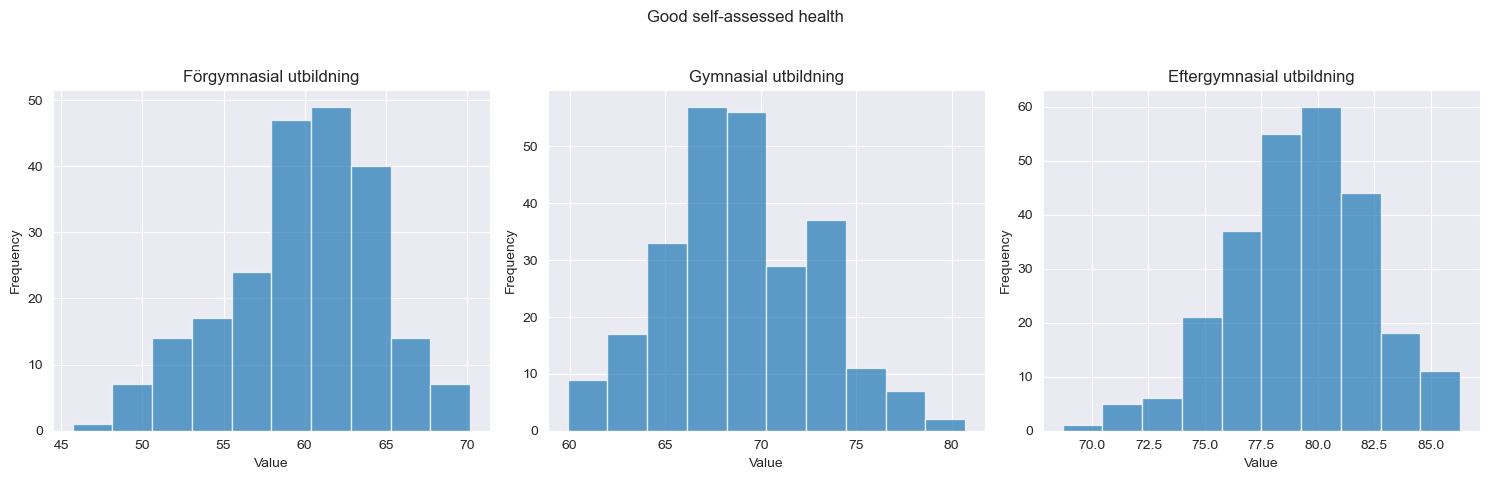

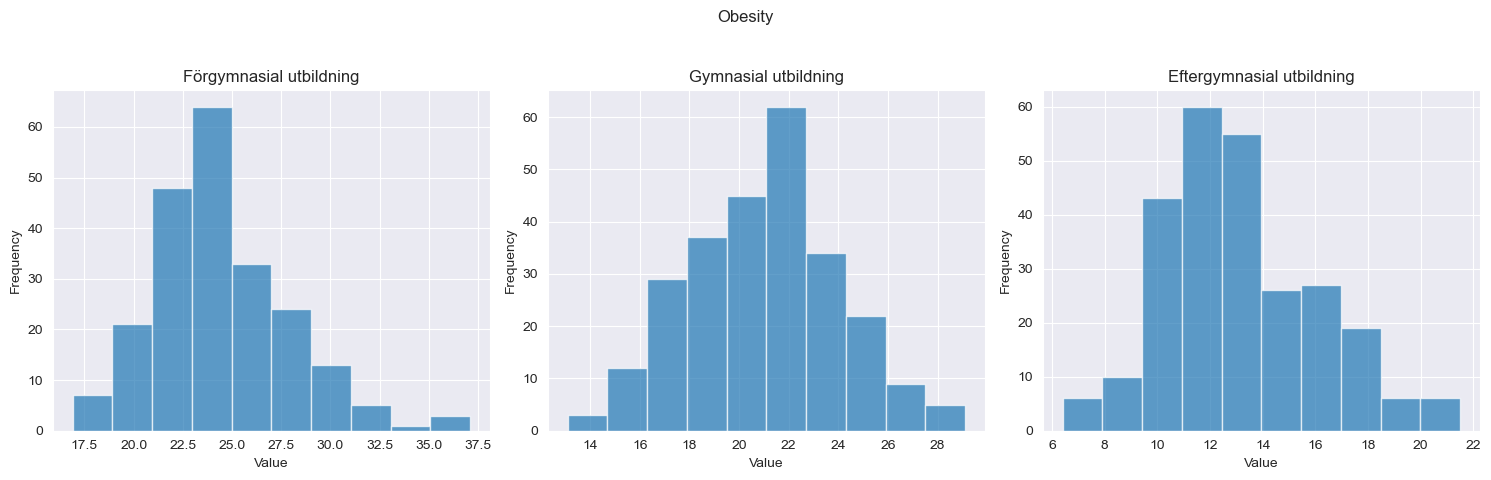

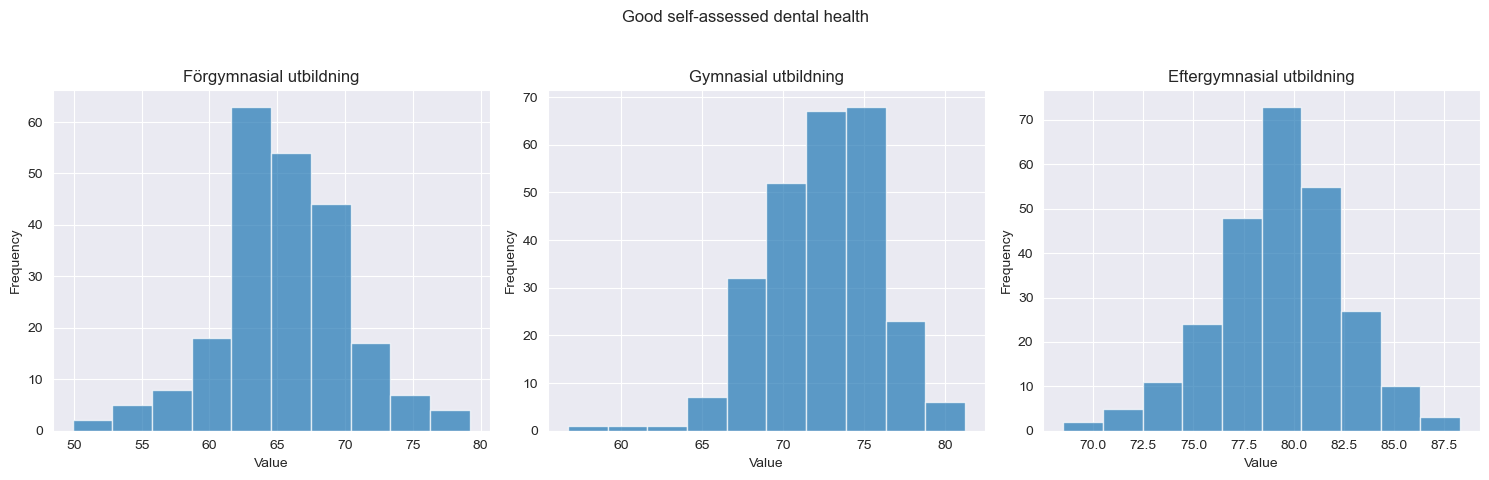

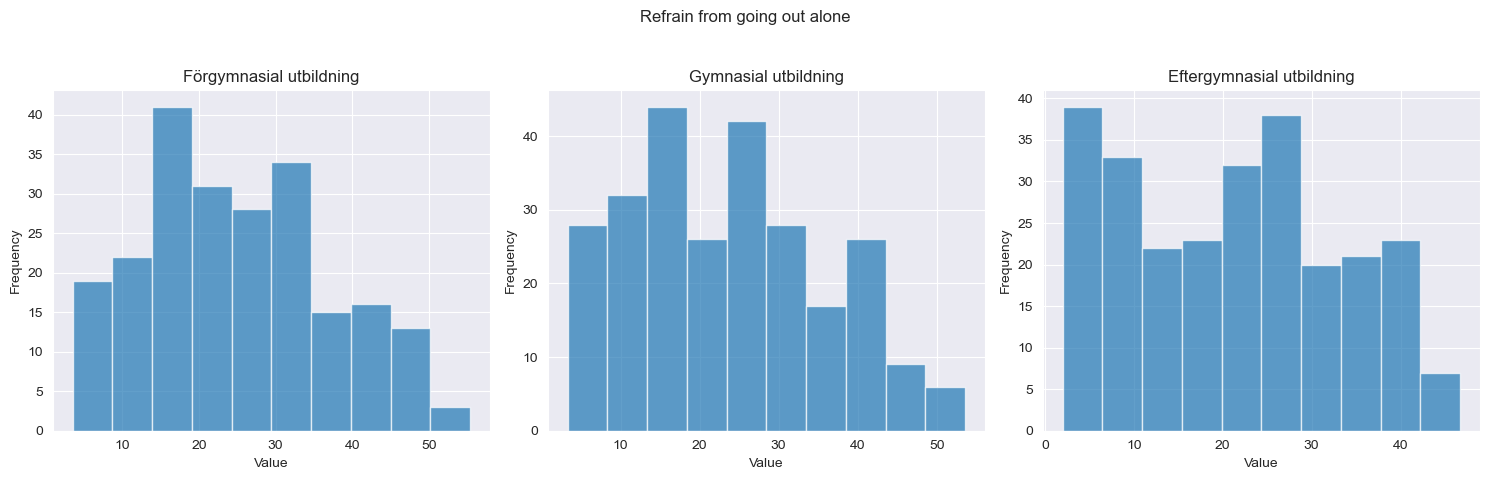

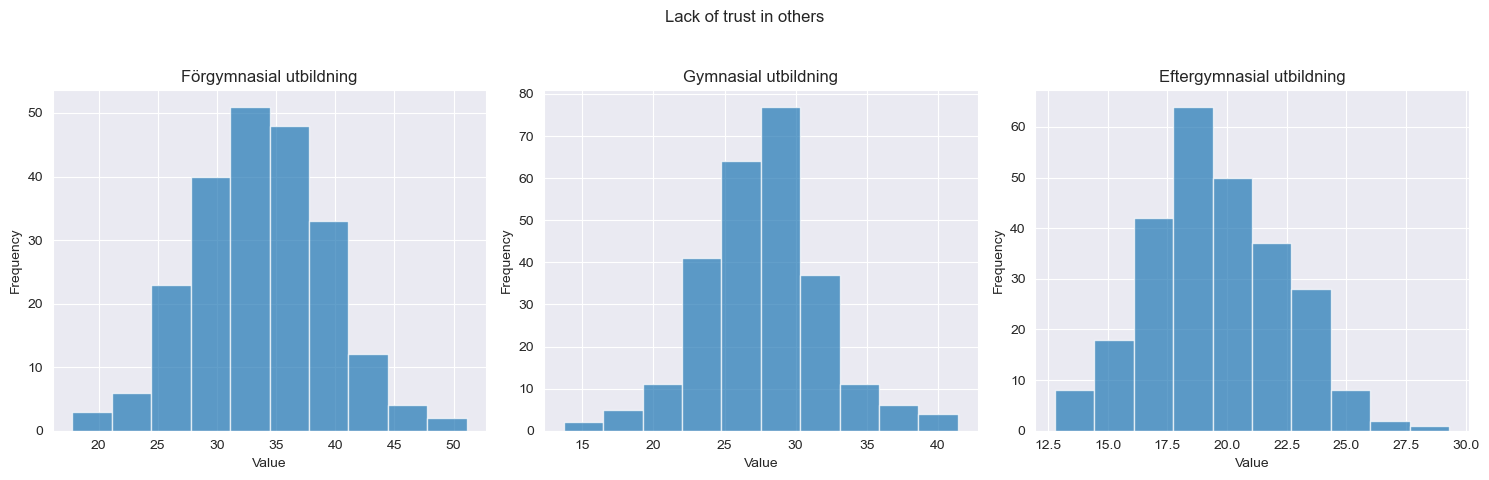

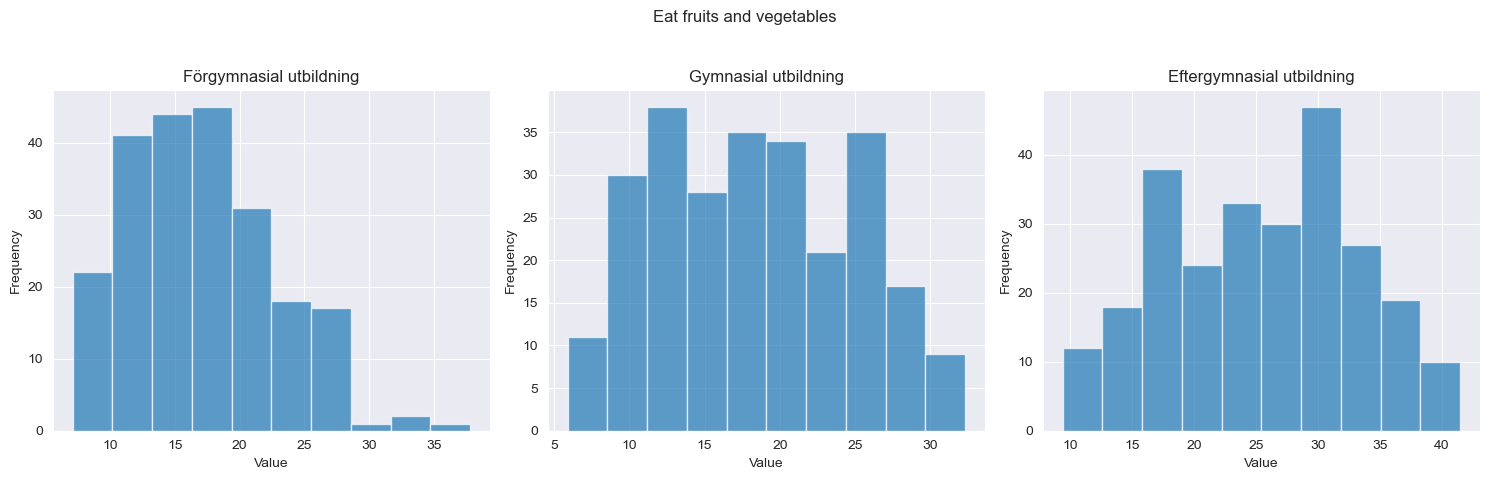

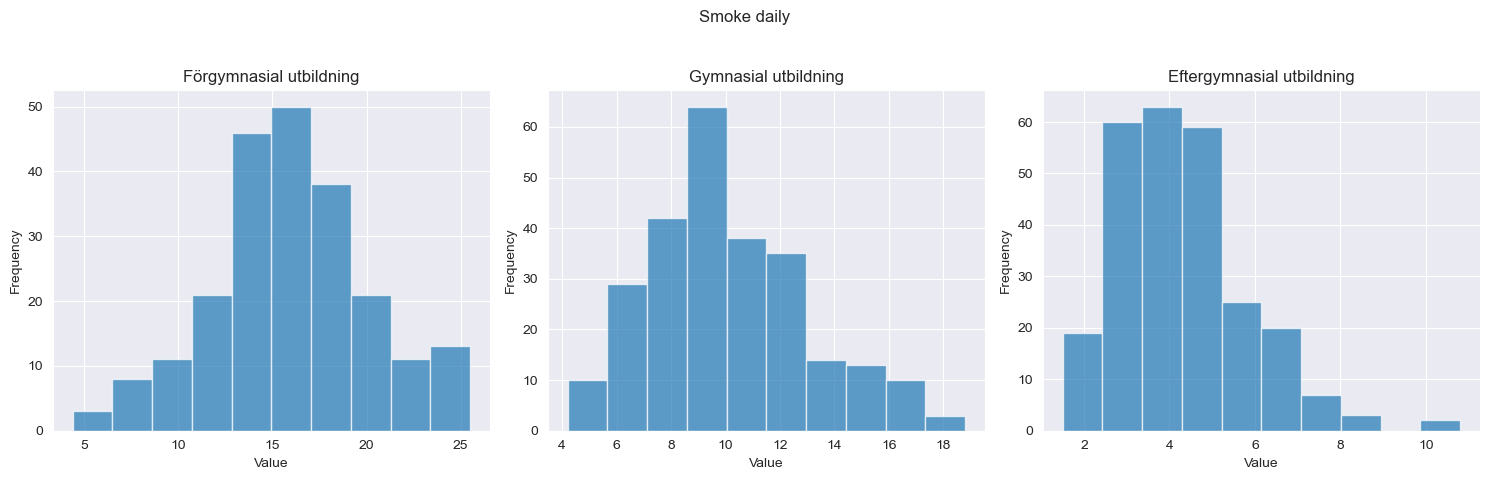

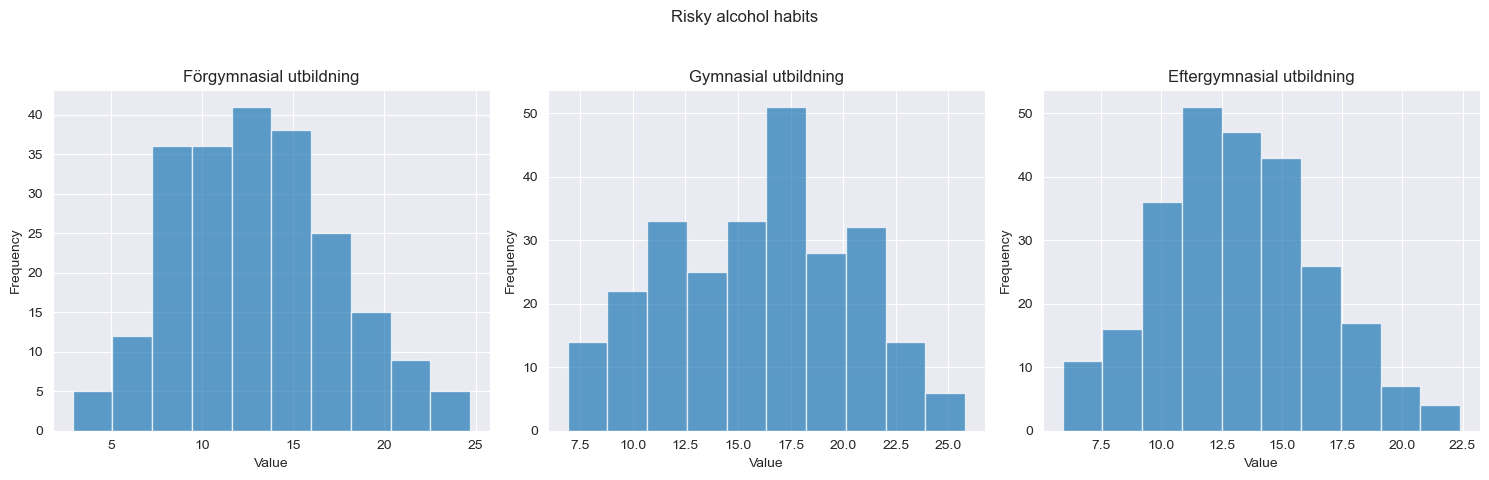

In [2]:
# Analysing the health contributors with different levels of education
# This is done to determine what KPIs are relevant to our analysis
education_health_kpis = [
    'U60507', 'U60508', 'U60509', # Good self-assessed health
    'U60510', 'U60511', 'U60512', # Obesity
    'U60514', 'U60515', 'U60516', # Good self-assessed dental health
    'U60525', 'U60526', 'U60527', # Refrain from going out alone
    'U60528', 'U60529', 'U60530', # Lack of trust in others
    'U60540', 'U60541', 'U60542', # Eat fruits and vegetables
    'U60543', 'U60544', 'U60545', # Smoke daily
    'U60547', 'U60548', 'U60549'  # Risky alcohol habits
]

# Filter the kpi_values dataframe for the KPIs of interest
filtered_df = kpi_values[kpi_values['kpi'].isin(education_health_kpis)]

kpi_groups = {
    'Good self-assessed health': ['U60507', 'U60508', 'U60509'],
    'Obesity': ['U60510', 'U60511', 'U60512'],
    'Good self-assessed dental health': ['U60514', 'U60515', 'U60516'],
    'Refrain from going out alone': ['U60525', 'U60526', 'U60527'],
    'Lack of trust in others': ['U60528', 'U60529', 'U60530'],
    'Eat fruits and vegetables': ['U60540', 'U60541', 'U60542'],
    'Smoke daily': ['U60543', 'U60544', 'U60545'],
    'Risky alcohol habits': ['U60547', 'U60548', 'U60549']
}

def extract_education_level(title):
    if 'eftergymnasial utbildning' in title:
        return 'Eftergymnasial utbildning'
    elif 'förgymnasial utbildning' in title:
        return 'Förgymnasial utbildning'
    elif 'gymnasial utbildning' in title:
        return 'Gymnasial utbildning'
    else:
        return 'Unknown Education Level'

# Create subplots for each category
for category, kpis in kpi_groups.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    fig.suptitle(category)

    for i, kpi in enumerate(kpis):
        subset = filtered_df[filtered_df['kpi'] == kpi]
        axes[i].hist(subset['value'], bins=10, alpha=0.7)
        kpi_title = kpi_names.get(kpi, kpi)
        simple_title = extract_education_level(kpi_title)
        axes[i].set_title(f'{simple_title}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Health Contributors: Observations
#### Good Self-Assessed Health
In the histograms above individuals with eftergymnasial utbildning tend to report better self-assessed health with a higher frequency of individuals rating their health in the higher value ranges. This indicates a potential correlation between higher education levels and better self-perceived health status.

#### Obesity
The obesity histograms suggest a trend where förgymnasial utbildning individuals have a wider spread of obesity values possibly indicating higher obesity rates. Conversely the eftergymnasial utbildning group shows a shift towards lower obesity values suggesting lower obesity rates among those with higher education.

#### Good Self-Assessed Dental Health
The distribution of good self-assessed dental health scores is notably higher for those with eftergymnasial utbildning emphasizing a possible link between post-gymnasium education and better dental health. However, not as connection as strong as the one observed for self-assessed health.

#### Refrain from Going Out Alone
The data for refraining from going out alone appears to be quite dispersed among all education levels, making it difficult to discern a clear pattern. However, the förgymnasial utbildning group shows a slight shift towards lower values indicating a higher frequency of individuals who refrain from going out alone.

#### Lack of Trust in Others
For lack of trust in others the gymnasial utbildning group shows a more pronounced peak which may indicate a higher tendency of mistrust compared to the other groups. This could suggest that social trust varies with education level however more investigation would be needed.

#### Eat Fruits and Vegetables
Consumption of fruits and vegetables appears relatively consistent across education levels. No clear trend indicating a significant difference based on education.

#### Smoke Daily
Daily smoking habits show a trend where those with förgymnasial utbildning exhibit a higher frequency of higher values potentially indicating that a lower education level leads to a higher prevalence of smoking.

#### Risky Alcohol Habits
The distribution of risky alcohol habits is relatively consistent across education levels. No clear trend indicating a significant difference based on education.

#### Conclusion
Our analysis highlights a notable association between education and certain health behaviors, particularly smoking, self-assessed health, and obesity. These findings will be pivotal as we delve deeper into understanding the influence of educational attainment on health outcomes. They will be central to the more detailed analyses that follow in our study.

### Purpose of the Study
The primary aim of this study is to explore the relationship between socioeconomic factors and health outcomes across Swedish regions with a particular focus on gender differences. It seeks to:

1. Examine how varying levels of education and income influence health indicators for both men and women within the diverse contexts of Sweden's regions.
2. Assess the differential impact of education and income on health outcomes between men and women to determine whether these socioeconomic factors affect genders largely.

Through this analysis, the study intends to contribute to the understanding of health disparities and identify areas where educational and economic interventions can be targeted to improve public health.

#### Research Question 1
* How does education and income affect both men and women's health in Swedish Regions?

#### Research Question 2
* Does the effect of income on men and women's health differ from the effect of education on health in Swedish Regions?

### KPI Choice Reasoning
The selection of Health KPIs is a fundamental step in our investigation to unravel the complex interactions between education, income, and health outcomes differentiated by gender. To capture a holistic view of health within the Swedish regions we have elected KPIs that not only measure direct health outcomes but also factors closely related to lifestyle and well-being. These KPIs are crucial in understanding the broader health landscape and identifying gender-specific health patterns.

#### Health KPIs
The following health KPIs have been carefully chosen to reflect both the perceived and actual health states across genders:
* N00351: Hälsa - Regionindex Kvinnor (Womens Health Regional Index)
* N00362: Hälsa - Regionindex Män (Mens Health Regional Index)
* N00923: Medellivslängd - Regionindex Män (Mens Life Expectancy Regional Index)
* N00925: Medellivslängd - Regionindex Kvinnor (Womens Life Expectancy Regional Index)
* U01402: Invånare 16-84 år som röker dagligen (Residents 16-84 years who smoke daily)
* U01405: Invånare med bra självskattat hälsotillstånd (Residents with good self-assessed health status)
* U01411: Invånare med fetma (Residents with obesity)

These indicators were selected because they offer insights into both subjective health perceptions and objective health outcomes such as life expectancy. Then the KPIs for smoking, self-assessed health and obesity were chosen given that we knew these were confounding variables of health.

#### Education KPIs
We have chosen the following education KPIs:
* N00352: Utbildning och kompetens - Regionindex Kvinnor (Womens Education and Competence Regional Index)
* N00363: Utbildning och kompetens - Regionindex Män (Mens Education and Competence Regional Index)

#### Income KPIs
Income's impact on health is multifaceted and complex. To untangle this, we have opted for KPIs that not only reflect income levels but also encapsulate the broader economic status, including wealth accumulation and earning capacity.

We have chosen the following income KPIs:
* N00348: Inkomst och förmögenheter - Regionindex Kvinnor (Womens Income and Wealth Regional Index)
* N00359: Inkomst och förmögenheter - Regionindex Män (Mens Income and Wealth Regional Index)
* N00349: Arbete och löner - Regionindex Kvinnor (Womens Work and Salary Regional Index)
* N00360: Arbete och löner - Regionindex Män (Mens Work and Salary Regional Index)

The rationale behind these selections is grounded in the premise that income and wealth are integral to accessing health resources and can be a predictor of health outcomes. By examining these KPIs, we aim to illuminate the gender-specific economic factors that may contribute to health disparities within and across the Swedish regions.


### Error Handling
In the process of compiling our data we encountered several instances of missing values especially within the municipal datasets, which were more pronounced than in the regional data. Additionally, we observed that certain KPIs only provided regional data and were limited to the year 2022.

To maintain the integrity and continuity of our analysis we made a strategic decision to focus exclusively on the regional data selecting only those KPIs that offered a consistent annual dataset. This approach was chosen to guarantee a comprehensive and complete dataset for a robust analysis.

Despite narrowing our scope to regional data we identified three instances of missing data points. To address this without compromising our dataset's completeness we substituted the missing values with the mean of the available regional data. This method ensures that our analysis remains consistent and reliable allowing us to draw meaningful conclusions from a fully populated dataset.

### Statistical Data Types
In this section we will explore the nature of the variables employed in our study. All the KPIs used in our dataset are classified as ratio data. This classification is critical for our analytical approach, as it enables us to perform precise quantitative comparisons across various Swedish regions. Here's a detailed look at these key variables:

#### Ratio Data
* **N00351: Hälsa - Regionindex Kvinnor (Women's Health Regional Index)**
    * This index quantifies the overall health status of women on a scale from 0 to 100 where 0 represents the poorest health status.
* **N00362: Hälsa - Regionindex Män (Men's Health Regional Index)**
    * Similar to the Women's Health Regional Index, this measures the health status of men standardized on a 0 to 100 scale.
* **N00923: Medellivslängd - Regionindex Män (Men's Life Expectancy Regional Index)**
    * This variable represents the average life expectancy of men in different regions providing valuable insights into regional health differences.
* **N00925: Medellivslängd - Regionindex Kvinnor (Women's Life Expectancy Regional Index)**
    * It reflects the average life expectancy of women an essential indicator in assessing overall public health.
* **N00352: Utbildning och kompetens - Regionindex Kvinnor (Women's Education and Competence Regional Index)**
    * This index evaluates the educational attainment and skill levels of women which is crucial for understanding the role of education in health and well-being.
* **N00363: Utbildning och kompetens - Regionindex Män (Men's Education and Competence Regional Index)**
    * Similar to its female counterpart, this index assesses the education and skills of men across regions.
* **N00348: Inkomst och förmögenheter - Regionindex Kvinnor (Women's Income and Wealth Regional Index)**
    * Measures the income and wealth levels of women, normalized on a scale from 0 to 100. This index provides insights into the economic status of women in different regions.
* **N00359: Inkomst och förmögenheter - Regionindex Män (Men's Income and Wealth Regional Index)**
    * Similar to the women's index this indicator quantifies men's income and wealth on a comparable 0 to 100 scale, allowing for direct comparisons of economic well-being between genders.
* **N00349: Arbete och löner - Regionindex Kvinnor (Women's Work and Salary Regional Index)** 
    * This index evaluates the employment and salary levels of women. It is a crucial variable for understanding labor market disparities and economic empowerment among women.
* **N00360: Arbete och löner - Regionindex Män (Men's Work and Salary Regional Index)**
    * Similar to the women's index, his metric assesses the employment status and salary levels of men providing a comprehensive view of gender dynamics in the workforce.
* **U01402: Invånare 16-84 år som röker dagligen (Residents 16-84 years who smoke daily)**
    * Represents the percentage of the population aged 16-84 who are daily smokers. This variable provides insights into the prevalence of smoking among the population.
* **U01405: Invånare med bra självskattat hälsotillstånd (Residents with good self-assessed health status)**
    * Captures the percentage of residents who rate their health as good or very good. This indicator provides insights into the subjective health perceptions of the population.
* **U01411: Invånare med fetma (Residents with obesity)**
    * This variable indicates the percentage of the population with obesity a key health indicator that has implications for various health policies and initiatives.

Through these variables we aim to construct a comprehensive understanding of the multifaceted nature of health, education, and income in Sweden. Our analysis seeks to not only determine these relationships but also to offer insights that could inform policy and contribute to the field of regional health studies.

In [3]:
# List of KPI IDs for each category
health_kpis = ['N00351', 'N00362', 'N00923', 'N00925', 'U01402', 'U01405', 'U01411']
education_kpis = ['N00352', 'N00363']
income_kpis = ['N00348', 'N00359', 'N00349', 'N00360']

# Filtering the kpi_values dataframe to create separate dataframes for each category
health_df = kpi_values[kpi_values['kpi'].isin(health_kpis)]
education_df = kpi_values[kpi_values['kpi'].isin(education_kpis)]
income_df = kpi_values[kpi_values['kpi'].isin(income_kpis)]

# Display the first few rows of each filtered dataframe
print(f"{health_df.head()}\n")
print(f"{education_df.head()}\n")
print(f"{income_df.head()}\n")

         kpi  municipality  period gender      value
3182  N00351             0    2022      T  63.598955
3183  N00351             1    2022      T  82.754882
3184  N00351             3    2022      T  68.787137
3185  N00351             4    2022      T  36.220026
3186  N00351             5    2022      T  69.022839

         kpi  municipality  period gender      value
3204  N00352             0    2022      T  55.581171
3205  N00352             1    2022      T  56.368334
3206  N00352             3    2022      T  58.781354
3207  N00352             4    2022      T  48.612333
3208  N00352             5    2022      T  55.041985

         kpi  municipality  period gender      value
3116  N00348             0    2022      T  23.053445
3117  N00348             1    2022      T  48.697470
3118  N00348             3    2022      T  22.569836
3119  N00348             4    2022      T   3.667282
3120  N00348             5    2022      T  21.125893


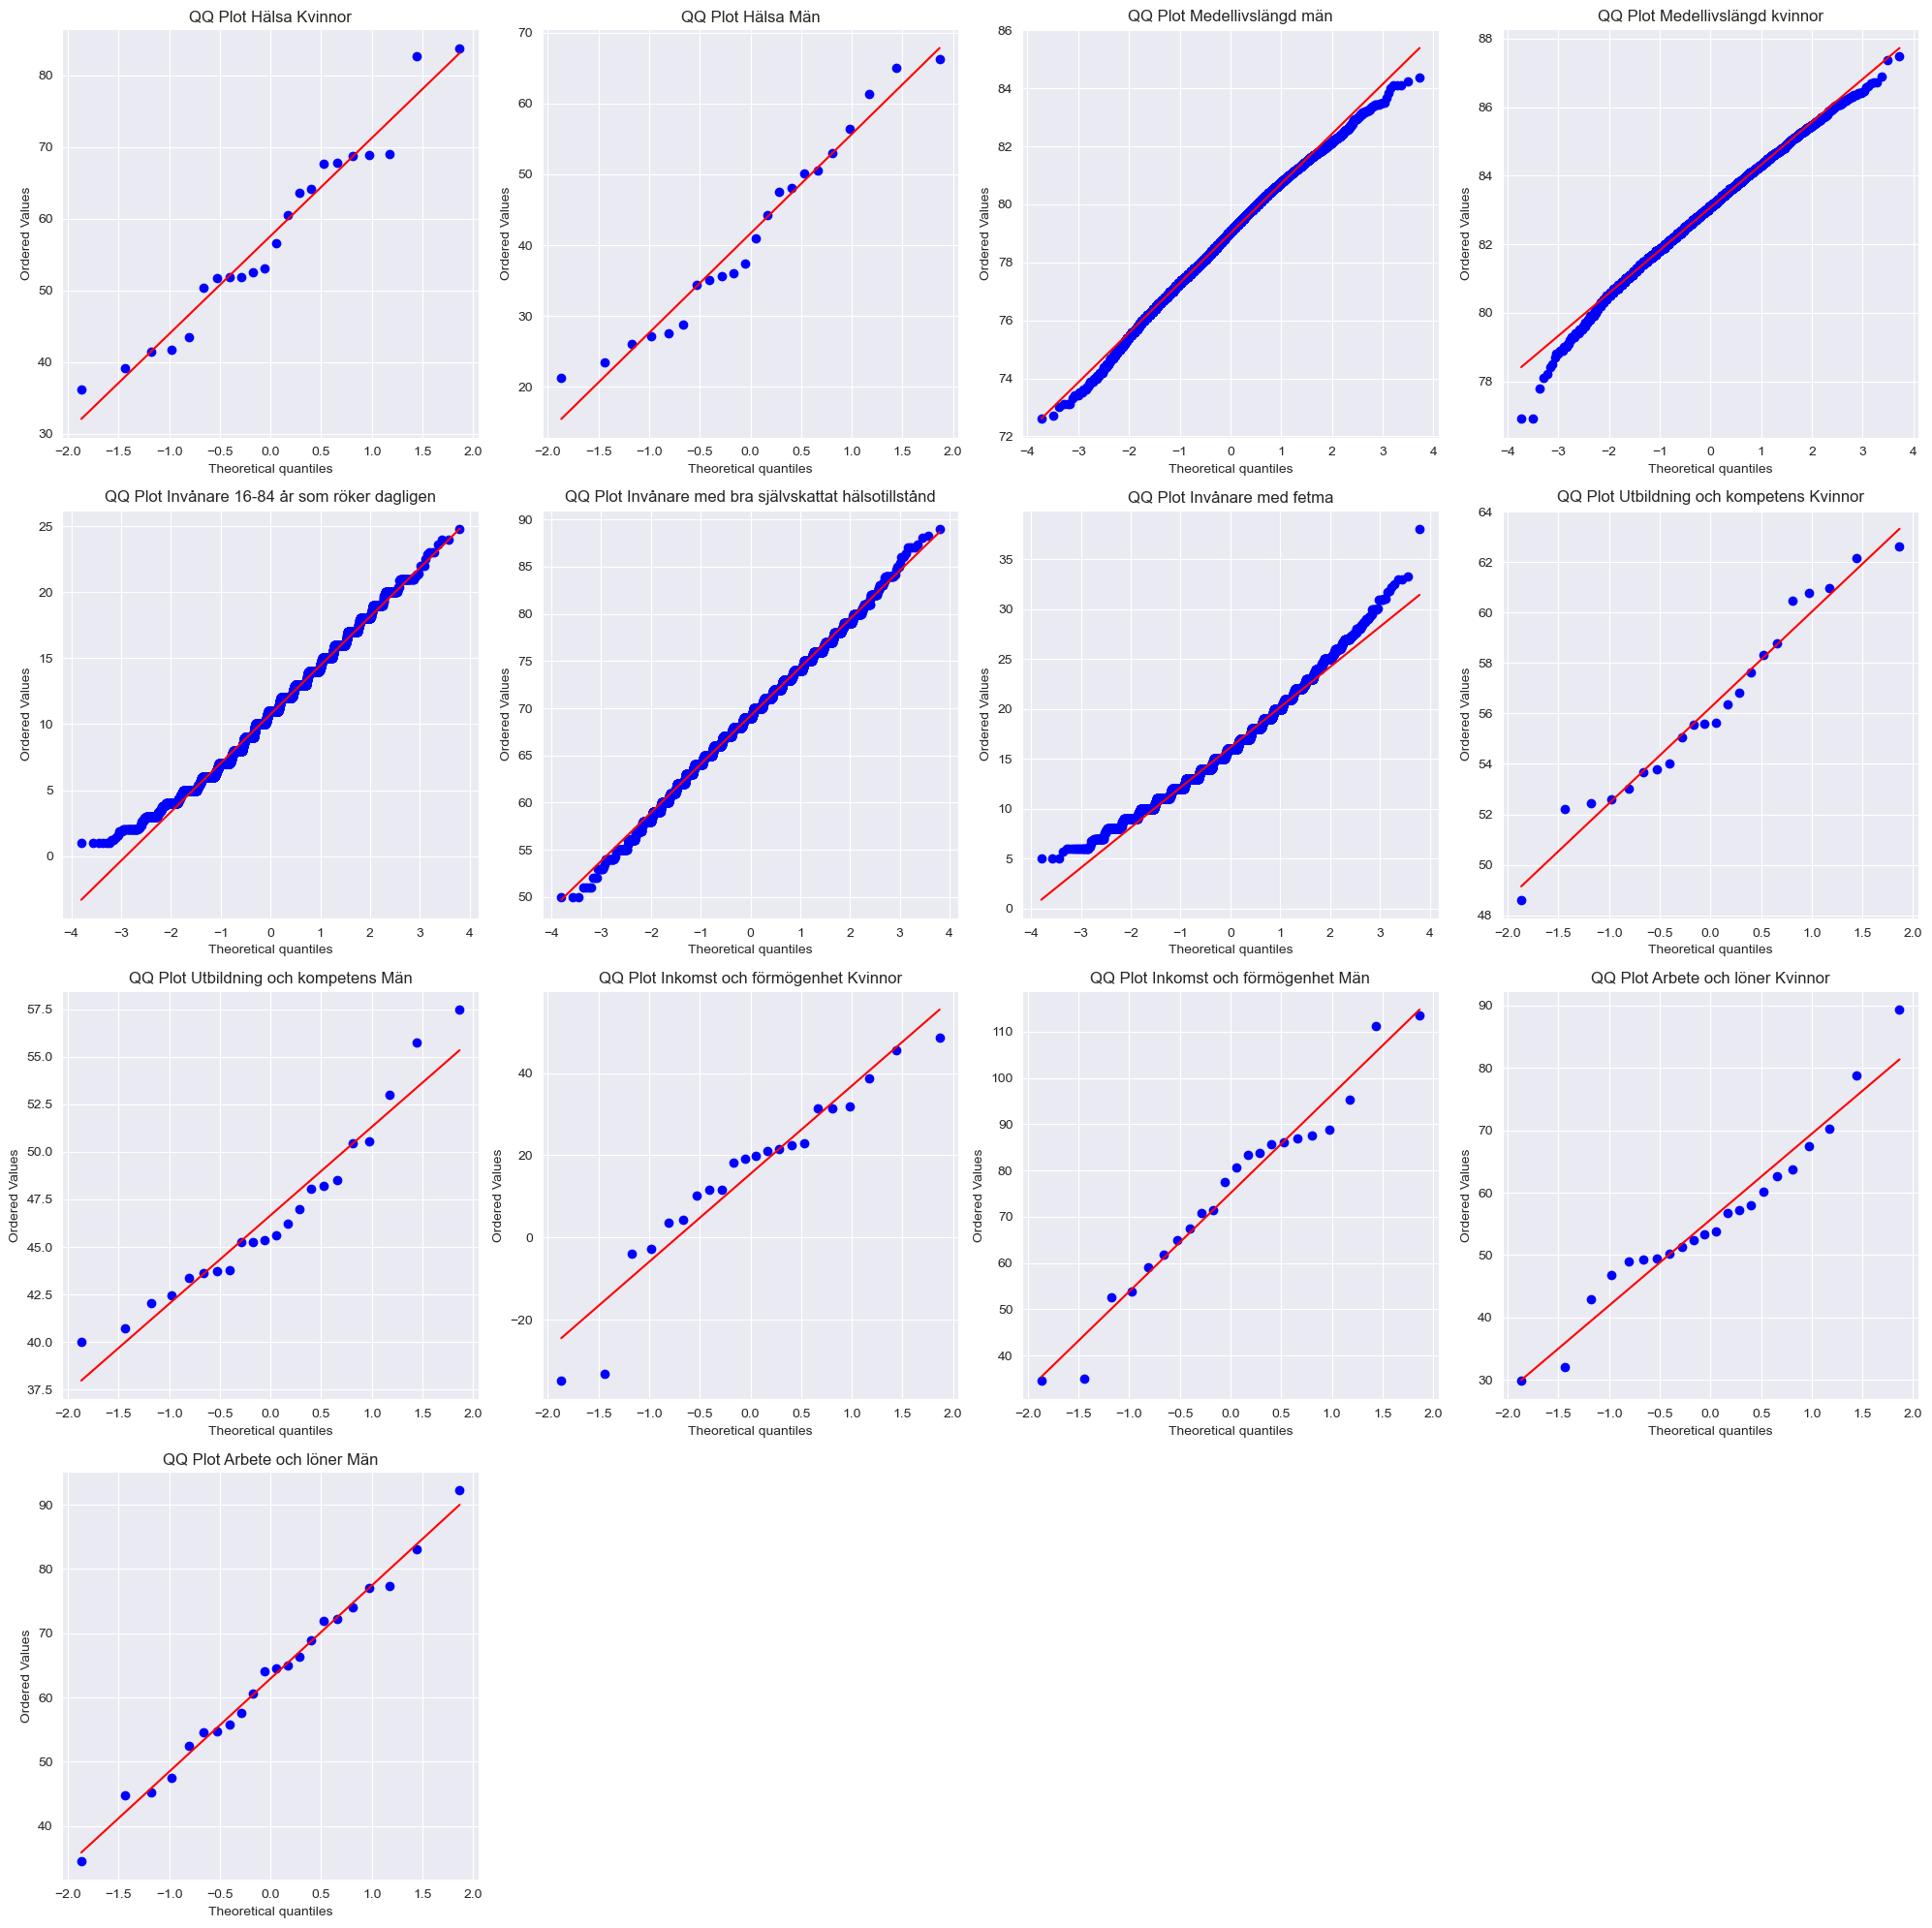

In [4]:
# Combine all the KPIs into a single dataframe
all_kpis_df = pd.concat([health_df, education_df, income_df])

# Combine all the lists to create a master list of KPIs
all_kpis = health_kpis + education_kpis + income_kpis

def create_qq_plots_for_kpis(kpi_list, df):
    # Define the number of rows and columns for the subplot grid
    num_plots = len(kpi_list)
    cols = 4  
    rows = num_plots // cols + (num_plots % cols > 0)

    # Create the subplots with the desired number of rows and columns
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Flatten the Axes array if there are multiple rows
    if num_plots > cols:
        axs = axs.flatten()

    for i, kpi in enumerate(kpi_list):
        # Filter for the KPI and total population
        data = df[df['kpi'] == kpi]['value']
        
        # Generate QQ plot
        stats.probplot(data, dist="norm", plot=axs[i])
        kpi_title = kpi_names.get(kpi, kpi)
        axs[i].set_title(f'QQ Plot {kpi_title.replace(", år", "").replace("Regionindex", "").replace(" – ", "").replace(", andel (%)", "").replace(" år (median), kr", "")}')

    # Hide any unused subplots
    for i in range(num_plots, rows * cols):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

# Generate QQ plots for all KPIs
create_qq_plots_for_kpis(all_kpis, all_kpis_df)

### QQ Plots: Observations
The Q-Q plots for each KPI provide insight into the normality of the distributions of our key indicators across different groups. In a perfectly normal distribution the points should fall along the 45-degree reference line.

* **Health Index for Women and Men:** The points closely follow the line, suggesting that the health index for both women and men is approximately normally distributed. This indicates that health outcomes across regions may be symmetrically distributed around a central value.
* **Life Expectancy for Men and Women:** The life expectancy distributions also adhere closely to the line especially in the middle quantiles. Any deviations in the tails might indicate some regional outliers or variations in life expectancy but overall the assumption of normality seems reasonable for these KPIs.
* **Daily Smokers and Self-Assessed Health Status:** The plots for daily smokers and self-assessed health status show that the data points deviate slightly from the line in the tails suggesting the potential presence of outliers or skewness in the data. However, the middle quantiles still align well with the theoretical distribution implying that for most regions these variables are normally distributed.
* **Education and Income Indexes:** The education and competence index and the income and wealth index for both men and women display a strong alignment with the reference line across all quantiles. This suggests that socioeconomic factors represented by these KPIs are well-modeled by a normal distribution in the Swedish regions.
* **Work and Salary Indexes:** The adherence of data points to the reference line in the work and salary indexes indicates that the economic conditions across regions are also approximately normally distributed.

The general adherence to the reference line in these Q-Q plots is important because it validates the use of parametric tests which assume normality in the data. If we had observed significant deviations from the line we would need to consider non-parametric methods or transformations to handle the non-normality.

By confirming that our KPIs are approximately normally distributed we can proceed with more sophisticated statistical analyses such as regression or ANOVA with added confidence.

 ### Exploratory Data Analysis

### Descriptive Statistics

In [5]:
# Determine the number of unique KPIs in each category
unique_kpis = all_kpis_df['kpi'].unique()

# Calculate descriptive statistics for each unique KPI
descriptive_stats = {kpi_names[kpi]: all_kpis_df[all_kpis_df['kpi'] == kpi]['value'].describe() for kpi in unique_kpis}

# Enhance readability with a formatted string
formatted_stats = ""
for kpi, stats in descriptive_stats.items():
    formatted_stats += f"Descriptive statistics for {kpi}:\n{stats}\n\n"

# Print the descriptive statistics
print(formatted_stats)

Descriptive statistics for Hälsa – Regionindex Kvinnor:
count    22.000000
mean     57.605826
std      13.277871
min      36.220026
25%      50.773805
50%      54.849984
75%      67.735886
max      83.833148
Name: value, dtype: float64

Descriptive statistics for Hälsa – Regionindex Män:
count    22.000000
mean     41.654250
std      13.576229
min      21.252717
25%      30.145915
50%      39.170170
75%      50.404391
max      66.242924
Name: value, dtype: float64

Descriptive statistics for Medellivslängd män, år:
count    7158.000000
mean       78.999892
std         1.716899
min        72.600000
25%        77.800000
50%        79.075000
75%        80.230000
max        84.370000
Name: value, dtype: float64

Descriptive statistics for Medellivslängd kvinnor, år:
count    7158.000000
mean       83.067685
std         1.250349
min        76.900000
25%        82.200000
50%        83.100000
75%        83.920000
max        87.480000
Name: value, dtype: float64

Descriptive statistics for Inv

### Descriptive Statistics: Observations
**Health Index for Women (Hälsa – Regionindex Kvinnor)**
* **Range:** 36.22 to 83.83
* **Mean:** 57.61
* **Standard Deviation:** 13.28
* **Quartiles:** 25% at 50.77, 50% at 54.85 (Median), 75% at 67.74

**Observation:** The health index for women varies widely across regions with a moderate average but significant spread as indicated by the standard deviation and range. The median is slightly lower than the mean suggesting a slight left skew in the data.

**Health Index for Men (Hälsa – Regionindex Män)**
* **Range:** 21.25 to 66.24
* **Mean:** 41.65
* **Standard Deviation:** 13.58
* **Quartiles:** 25% at 30.15, 50% at 39.17, 75% at 50.40

**Observation:** Men's health index shows a lower average than women's with a similar standard deviation indicating variability across regions. The median is lower than the mean indicating a left skew in the distribution.

**Men's Life Expectancy (Medellivslängd män, år)**
* **Range:** 72.60 to 84.37
* **Mean:** 79.00
* **Standard Deviation:** 1.72
* **Quartiles:** 25% at 77.80, 50% at 79.08, 75% at 80.23

**Observation:** Life expectancy for men is quite consistent with a narrow standard deviation relative to the mean suggesting that most regions have similar life expectancy values.

**Women's Life Expectancy (Medellivslängd kvinnor, år)**
* **Range:** 76.90 to 87.48
* **Mean:** 83.07
* **Standard Deviation:** 1.25
* **Quartiles:** 25% at 82.20, 50% at 83.10, 75% at 83.92

**Observation:** Women's life expectancy is higher on average than men's with a lower standard deviation,indicating less variability and a more consistent life expectancy across regions.

**Daily Smokers 16-84 Years (Invånare 16-84 år som röker dagligen)**
* **Range:** 1.00 to 24.80
* **Mean:** 10.75
* **Standard Deviation:** 3.71
* **Quartiles:** 25% at 8.00, 50% at 11.00, 75% at 13.00

**Observation:** The percentage of daily smokers shows moderate variability. The distribution is fairly symmetrical around the mean as the median is close to the mean.

**Good Self-Assessed Health Status (Invånare med bra självskattat hälsotillstånd)**
* **Range:** 50.00 to 89.00
* **Mean:** 69.20
* **Standard Deviation:** 5.13
* **Quartiles:** 25% at 66.00, 50% at 69.00, 75% at 73.00

**Observation:** The self-assessed health status demonstrates a positive outlook with a relatively high mean. The distribution is symmetrical and consistent across regions as indicated by the small standard deviation.

**Obesity Prevalence (Invånare med fetma)**
* **Range:** 5.00 to 38.07
* **Mean:** 16.16
* **Standard Deviation:** 4.05
* **Quartiles:** 25% at 13.00, 50% at 16.00, 75% at 19.00

**Observation:** There is a noticeable spread in obesity rates across regions. The mean and median are closely aligned suggesting a relatively symmetric distribution.

**Women's Education and Competence Index (Utbildning och kompetens – Regionindex Kvinnor)**
* **Range:** 48.61 to 62.64
* **Mean:** 56.23
* **Standard Deviation:** 3.67
* **Quartiles:** 25% at 53.71, 50% at 55.61, 75% at 58.66

**Observation:** The education and competence index for women shows a fairly tight distribution around the mean representing consistency in educational attainment among regions.

**Men's Education and Competence Index (Utbildning och kompetens – Regionindex Män)**
* **Range:** 40.00 to 57.48
* **Mean:** 46.66
* **Standard Deviation:** 4.57
* **Quartiles:** 25% at 43.68, 50% at 45.50, 75% at 48.43

**Observation:** Men's education index is generally lower than women's with a wider range indicating more variability in men's educational levels across regions.

**Women's Income and Wealth Index (Inkomst och förmögenhet – Regionindex Kvinnor)**
* **Range:** -34.72 to 48.70
* **Mean:** 15.50
* **Standard Deviation:** 21.22
* **Quartiles:** 25% at 5.91, 50% at 19.60, 75% at 29.29

**Observation:** The index for women's income and wealth exhibits a considerable range indicating significant difference across regions. The negative value in the range and a mean that is closer to the third quartile suggest a distribution that is skewed towards higher income regions.

**Men's Income and Wealth Index (Inkomst och förmögenhet – Regionindex Män)**
* **Range:** 34.57 to 113.45
* **Mean:** 75.07
* **Standard Deviation:** 20.62
* **Quartiles:** 25% at 62.66, 50% at 79.04, 75% at 86.70

**Observation:** The men's income and wealth index has a very wide range with the minimum far exceeding zero reflecting a high baseline level of income and wealth.T he distribution shows a positive skew with the mean exceeding the median meaning that a smaller number of regions have significantly higher income and wealth levels.

**Women's Work and Salary Index (Arbete och löner – Regionindex Kvinnor)**
* **Range:** 29.91 to 89.33
* **Mean:** 55.67
* **Standard Deviation:** 13.48
* **Quartiles:** 25% at 49.33, 50% at 53.57, 75% at 62.07

**Observation:** There is substantial variability in women's work and salary conditions across regions. The mean lies closer to the median meaning a relatively symmetrical distribution however the range indicates a notable difference between the highest and lowest values.

**Men's Work and Salary Index (Arbete och löner – Regionindex Män)**
* **Range:** 34.52 to 92.24
* **Mean:** 62.94
* **Standard Deviation:** 13.87
* **Quartiles:** 25% at 54.63, 50% at 64.32, 75% at 72.13

**Observation:** The index for men's work and salary also shows significant variation similar to that observed in the women's index. However, men's average values are higher and the distribution is skewed to the right suggesting that more men are concentrated in the higher salary and work condition brackets.

### Histograms

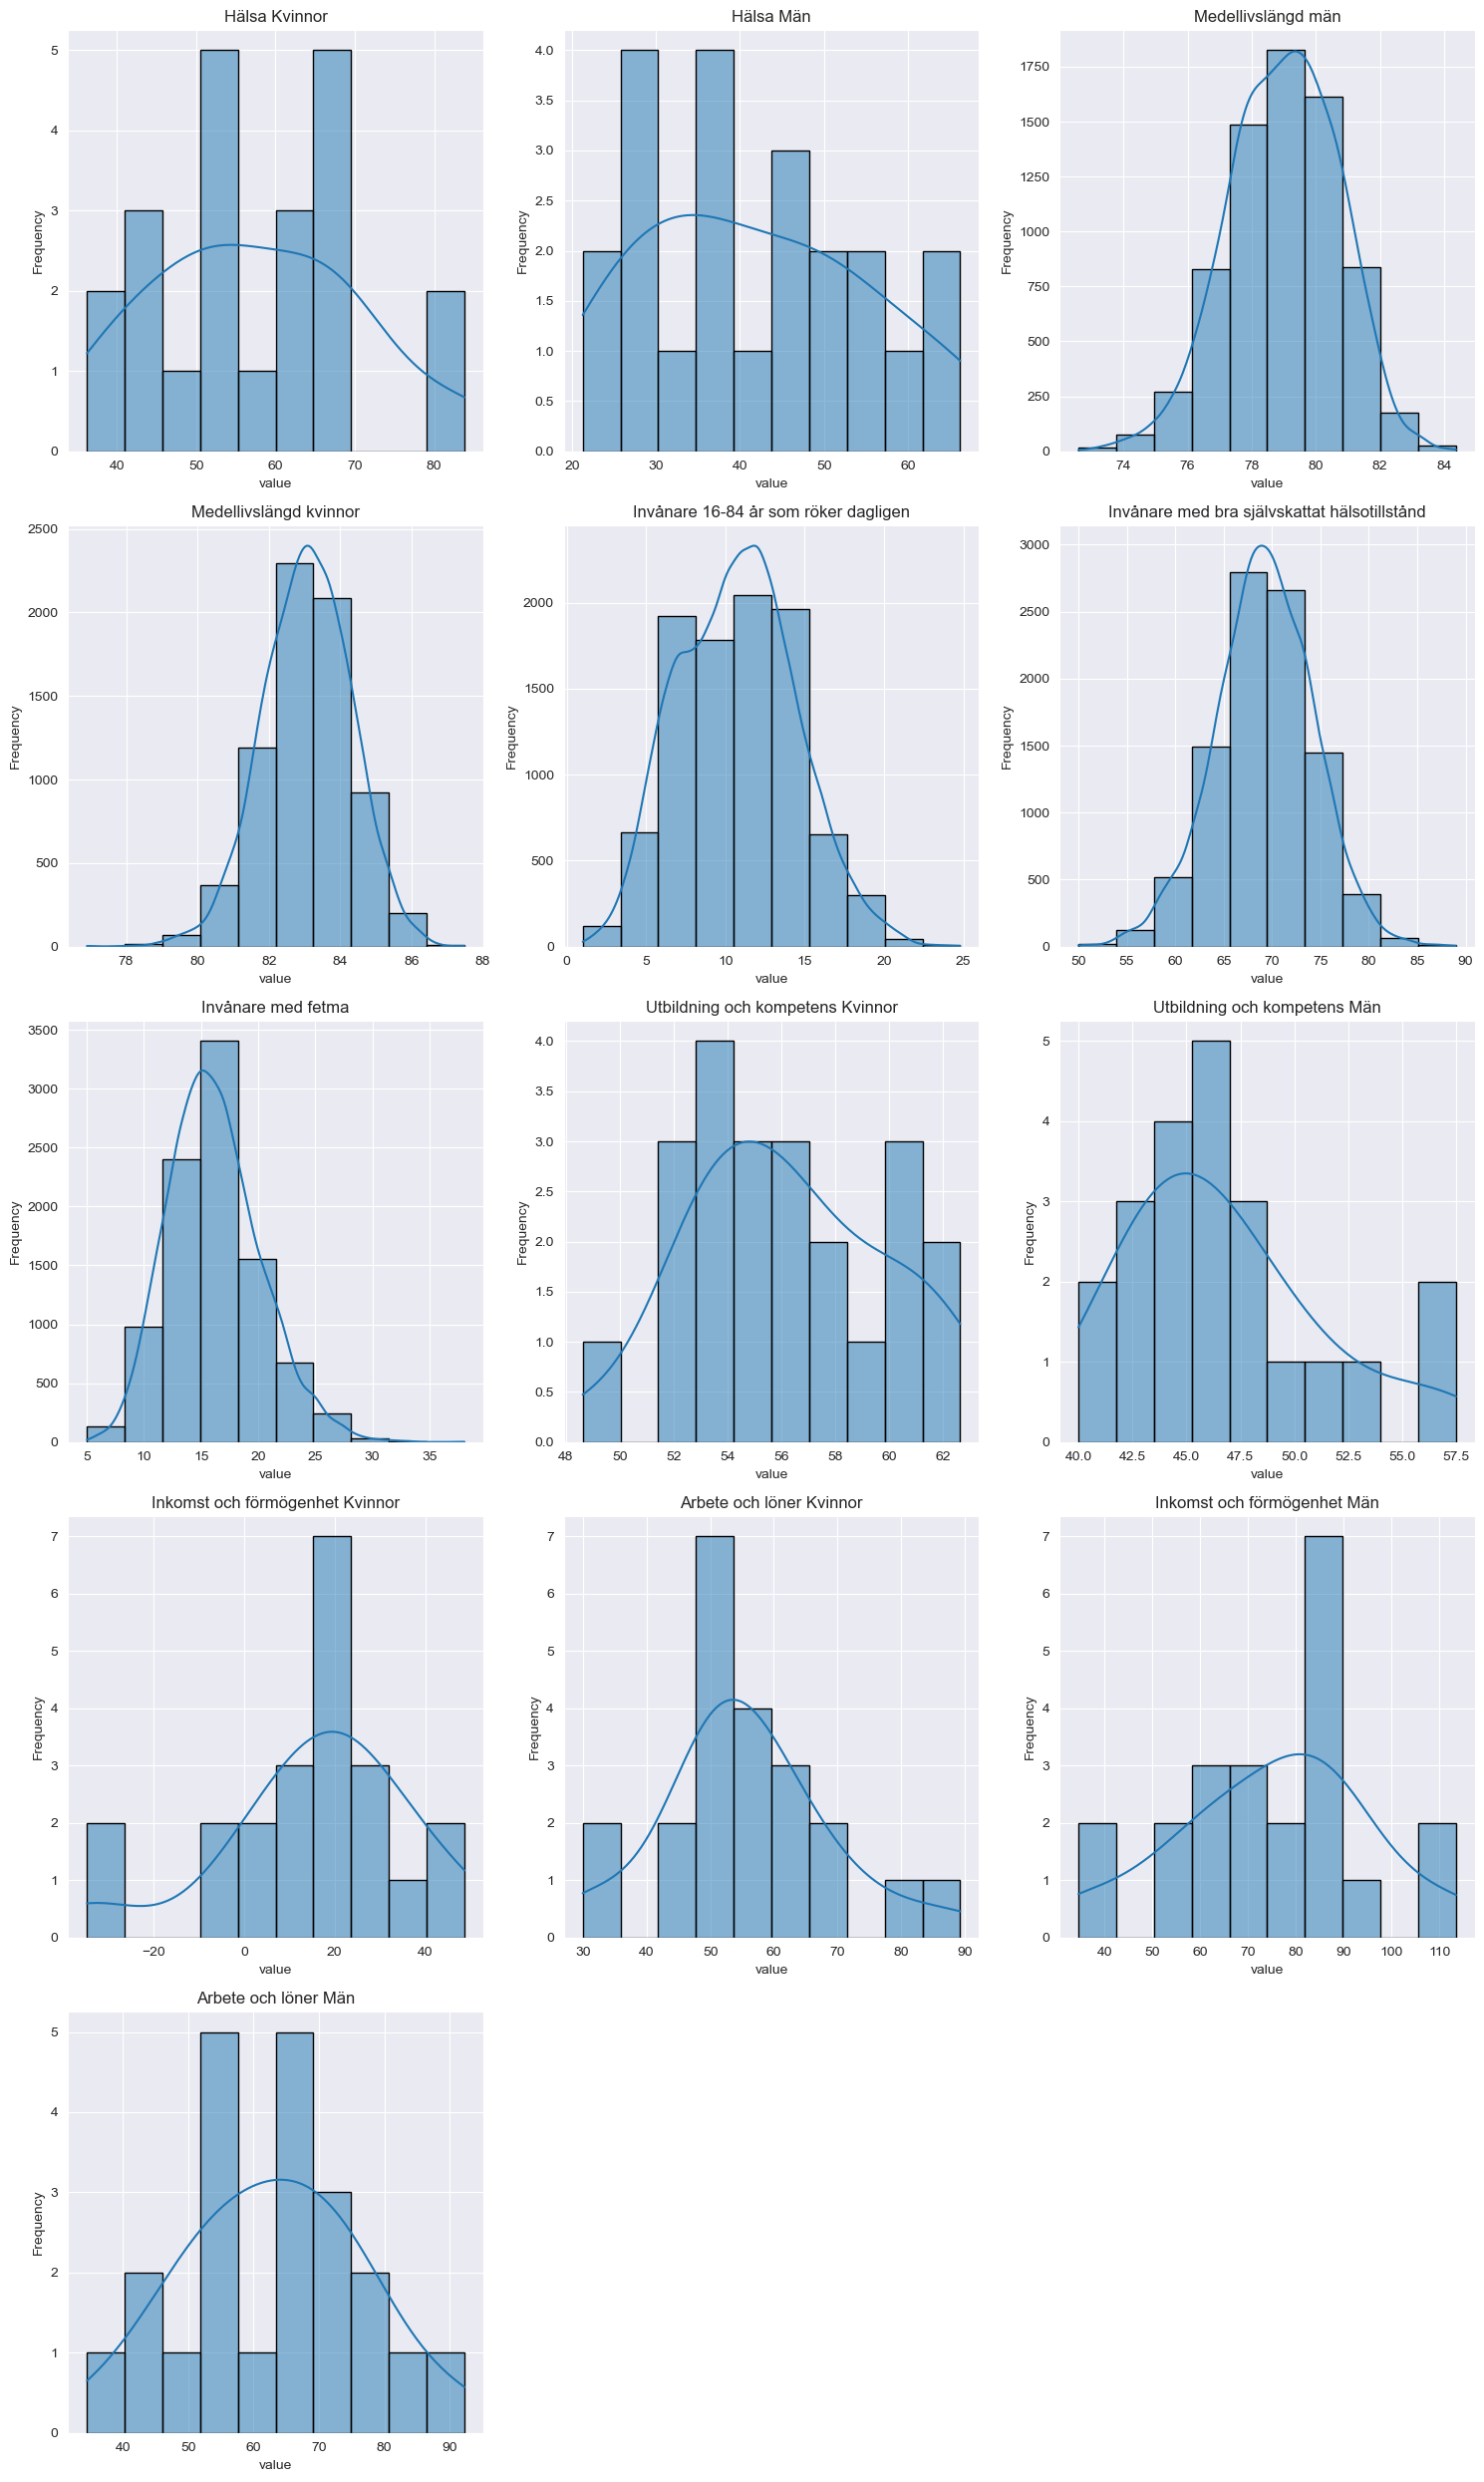

In [6]:
def plot_kpi_histograms(df, kpi_names, num_bins=10, num_cols=3):
    # Extract unique KPIs from the DataFrame
    unique_kpis = df['kpi'].unique()

    # Adjust the size of the plot based on the number of unique KPIs
    num_rows = len(unique_kpis) // num_cols + (len(unique_kpis) % num_cols > 0)  # Calculate the number of rows needed
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust the size dynamically

    # Check if axs is an array of axes, if not, wrap it in an array for consistency
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    # Flatten the Axes array for easy iteration
    axs = axs.flatten()

    # Plot a histogram for each KPI
    for i, kpi in enumerate(unique_kpis):
        # Select the data for the current KPI
        data = df[df['kpi'] == kpi]['value']

        # Plot the histogram using seaborn
        sns.histplot(data, bins=num_bins, ax=axs[i], kde=True, edgecolor='black')

        # Map the kpi to its name for the title
        kpi_name = kpi_names.get(kpi, kpi)
        axs[i].set_title(f'{kpi_name.replace(", år", "").replace("Regionindex", "").replace(" – ", "").replace(", andel (%)", "").replace(" år (median), kr", "")}')
        axs[i].set_ylabel('Frequency')

    # Hide any unused axes if the number of KPIs doesn't fill the grid
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_kpi_histograms(all_kpis_df, kpi_names)

### Histogram: Observations
**Women's Health Index & Men's Health Index**
* The histograms for both the Women's and Men's Health Index show a non-uniform distribution. The Women's Health Index appears slightly left-skewed suggesting that fewer regions have lower health index scores. The Men's Health Index exhibits a more even distribution but still with a tendency towards the left indicating a concentration of regions with lower health scores.

**Life Expectancy**
* For both men and women the life expectancy histograms are bell-shaped and resemble a normal distribution suggesting that the life expectancy across regions does not vary widely and most regions cluster around the mean life expectancy.

**Daily Smokers**
* The histogram for residents who smoke daily shows a right-skewed distribution indicating that the majority of regions have a lower percentage of daily smokers with fewer regions having a higher percentage.

**Good Self-Assessed Health Status**
* The distribution of residents with good self-assessed health status appears to be approximately normal suggesting a consistent assessment of health status across regions.

**Residents with Obesity**
* The histogram for residents with obesity is also approximately normally distributed indicating that obesity rates are fairly consistent across regions.

**Education and Competence Index**
* The histograms for the Education and Competence Index for both women and men show an approximately normal distribution indicating a balanced spread of education levels across regions.

**Income and Wealth Index**
* Women's Income and Wealth Index shows a peak at lower values with fewer regions at the high-end revealing a disparity in economic status. Men's distribution is right-skewed indicating higher income and wealth levels are more common and varied across regions highlighting a clear gender income gap in Sweden.

**Work and Salary Index**
* The histogram for women shows salaries are relatively consistent across regions but tend to cluster at lower levels while men's distribution suggests higher and more varied salaries pointing to a significant gender salary difference within Sweden.

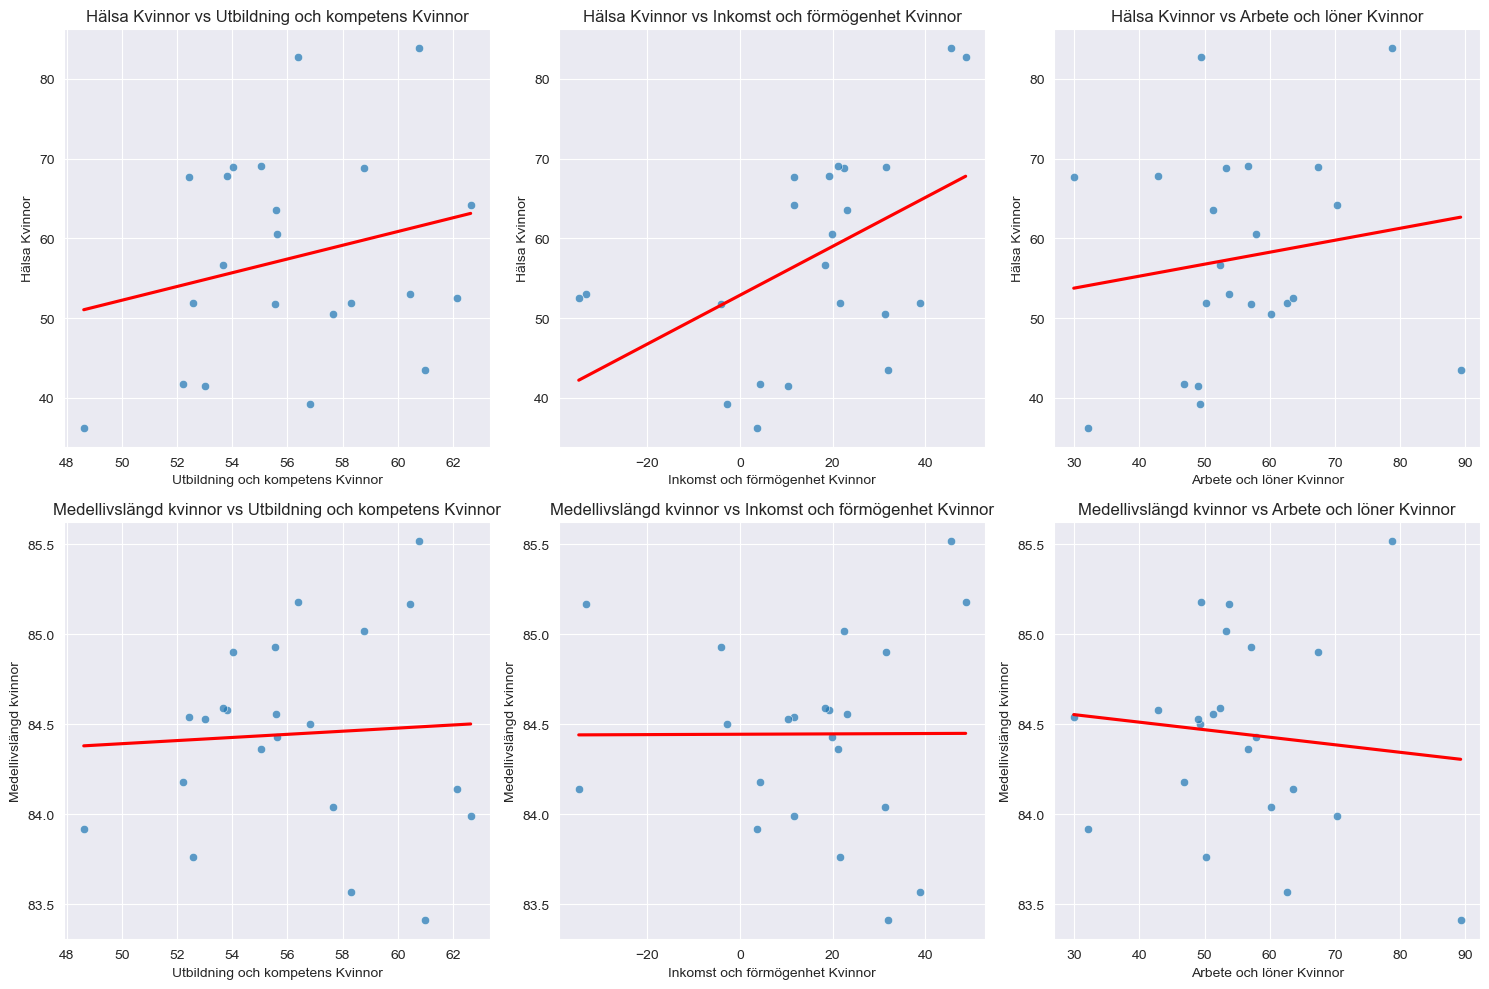

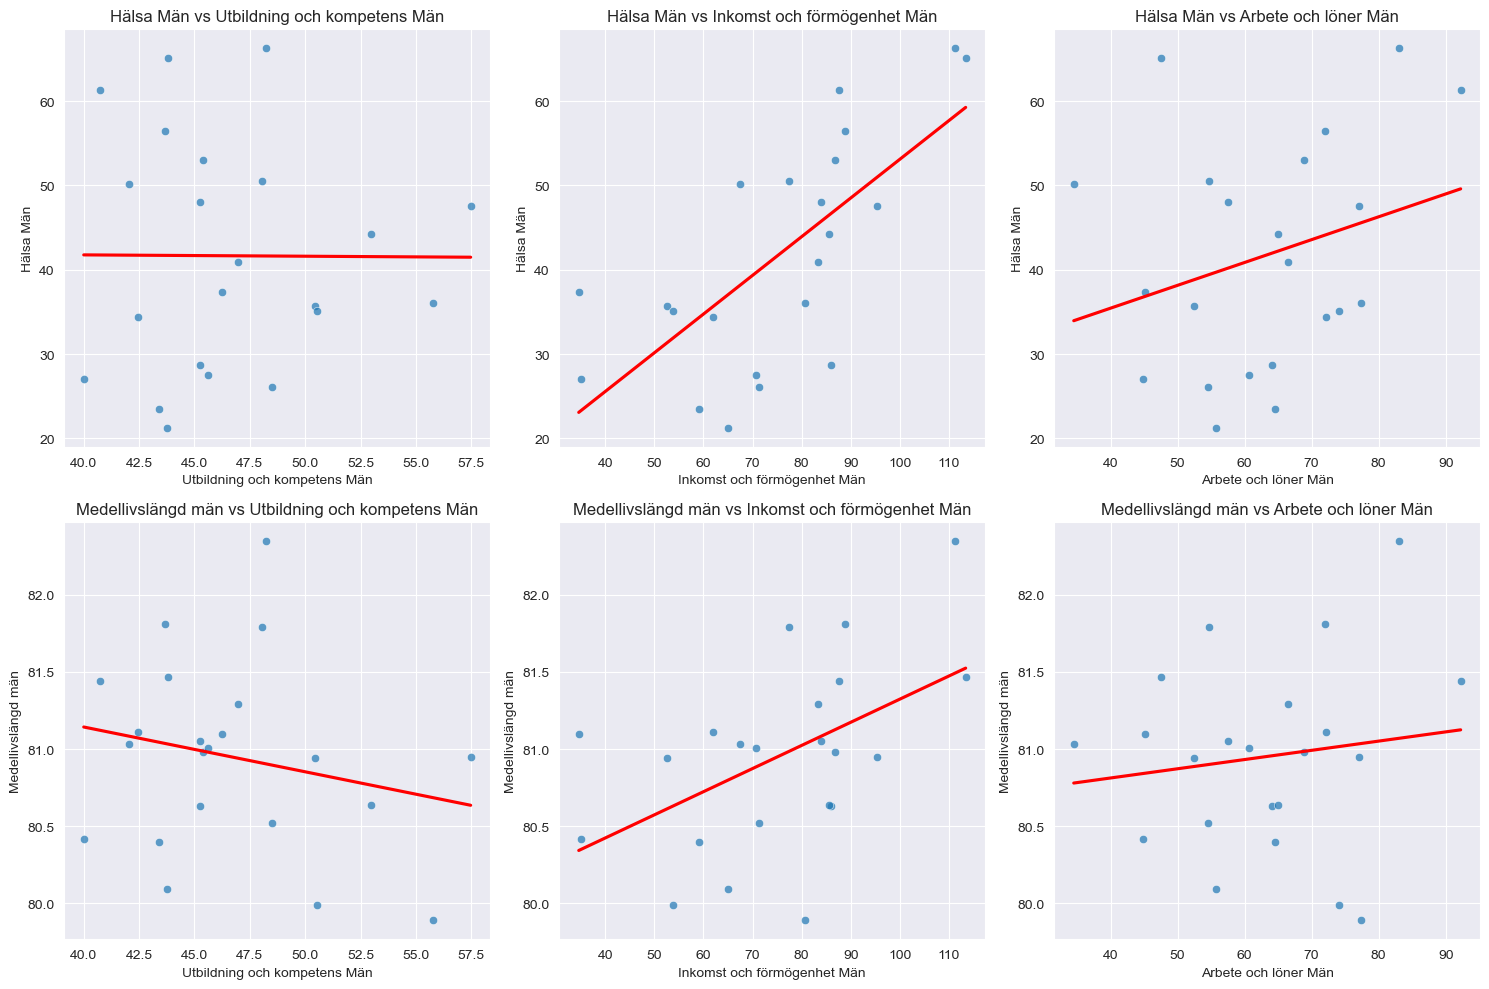

In [7]:
# Filter the DataFrame to only include data from the year 2022
df_2022 = all_kpis_df[all_kpis_df['period'] == 2022]

# Define dependent and independent variables for women
dependent_vars_women = ['N00351', 'N00925']  # Women's health and life expectancy
independent_vars_women = ['N00352', 'N00348', 'N00349']  # Women's education, income, work and wages

# Define dependent and independent variables for men
dependent_vars_men = ['N00362', 'N00923']  # Men's health and life expectancy
independent_vars_men = ['N00363', 'N00359', 'N00360']  # Men's education, income, work and wages

# Function to create scatter plots with trend lines for a given gender
def create_scatter_plots(df, dependent_vars, independent_vars, kpi_names):
    # Calculate the total number of plots
    total_plots = len(dependent_vars) * len(independent_vars)

    # Define the number of columns
    cols = 3

    # Calculate the number of rows needed
    rows = total_plots // cols + (total_plots % cols > 0)

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = axs.flatten()

    # Plot counter
    plot_count = 0

    for dep_var in dependent_vars:
        for ind_var in independent_vars:
            # Merge the data on 'municipality' for the specific KPIs
            dep_data = df[df['kpi'] == dep_var]
            ind_data = df[df['kpi'] == ind_var]
            merged_data = pd.merge(dep_data, ind_data, on='municipality', suffixes=('_dep', '_ind'))

            # Look up the KPI names using the kpi_names dictionary
            dep_var_name = kpi_names[dep_var] if dep_var in kpi_names else dep_var
            ind_var_name = kpi_names[ind_var] if ind_var in kpi_names else ind_var

            # Remove 'Regionindex' from the names and split at '–' and remove ', år'
            dep_var_name = ' '.join([part.strip() for part in dep_var_name.replace('Regionindex', '').split('–')]).replace(', år', '').strip()
            ind_var_name = ' '.join([part.strip() for part in ind_var_name.replace('Regionindex', '').split('–')]).replace(', år', '').strip()

            # Create the scatter plot on the appropriate subplot
            sns.scatterplot(x=merged_data['value_ind'], y=merged_data['value_dep'], alpha=0.7, ax=axs[plot_count])
            sns.regplot(x=merged_data['value_ind'], y=merged_data['value_dep'], scatter=False, ci=None, color='red', ax=axs[plot_count])

            # Set the title with the KPI names
            axs[plot_count].set_title(f'{dep_var_name} vs {ind_var_name}')
            axs[plot_count].set_xlabel(f'{ind_var_name}')
            axs[plot_count].set_ylabel(f'{dep_var_name}')

            # Increment the plot counter
            plot_count += 1

    # Hide any unused subplots
    for i in range(plot_count, rows * cols):
        fig.delaxes(axs[i])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Create scatter plots for women
create_scatter_plots(df_2022, dependent_vars_women, independent_vars_women, kpi_names)

# Create scatter plots for men
create_scatter_plots(df_2022, dependent_vars_men, independent_vars_men, kpi_names)

### Dependence Observations from Scatter Plots
**Women's Health vs Education**
* There appears to be a positive relationship between women's health index and education index as indicated by the upward trend line. This suggests that higher educational attainment among women may be associated with better health outcomes.

**Women's Health vs Income and Wealth**
* The scatter plot shows a positive correlation between women's health index and their income and wealth index. It implies that regions where women have higher income and wealth metrics also tend to report better health indices.

**Women's Health vs Work and Salary**
* The relationship between women's health index and their work and salary index is less clear suggesting a weaker association. However, the positive slope indicates that there might be a positive correlation between better work conditions/salaries and health.

**Women's Life Expectancy vs Education**
* Women's life expectancy has a very flat trend line when plotted against the education index implying there is little to no strong linear relationship between these variables.

**Women's Life Expectancy vs Income and Wealth**
* Similarly, women's life expectancy does not display a strong dependence on income and wealth.

**Women's Life Expectancy vs Work and Salary**
* The scatter plot for life expectancy against work and salary conditions also presents a flat trend line indicating a lack of strong correlation between these factors.

**Men's Health vs Education**
* The scatter plot presents a relatively flat trend line indicating a weak linear relationship between men's health and education.

**Men's Health vs Income and Wealth**
* There is a clear positive trend visible in the scatter plot suggesting that regions where men have higher income and wealth also tend to have better health.

**Men's Health vs Work and Salary**
* The scatter plot reveals a positive correlation between men's health index and work and salary index. This suggests that better work conditions and higher salaries may be associated with better health outcomes for men.

**Men's Life Expectancy vs Education**
* A slight positive trend is observed. However, the spread of the data points suggests that factors other than education might have a more significant impact on life expectancy among men.

**Men's Life Expectancy vs Income and Wealth**
* The plot shows a positive relationship between men's life expectancy and income and wealth. This could mean that higher economic status contributes to longer life expectancy.

**Men's Life Expectancy vs Work and Salary**
* A positive correlation is also noticeable here hinting that life expectancy for men may be influenced by their employment status and earnings.

Our findings underscore the significance of socioeconomic determinants in influencing health outcomes across genders within Swedish regions. While the data reveal clear positive correlations the variability in their magnitude suggests an indepth problem where additional unexplored variables may exert substantial influence. This complexity invites further exploration into the broader determinants of health disparities.

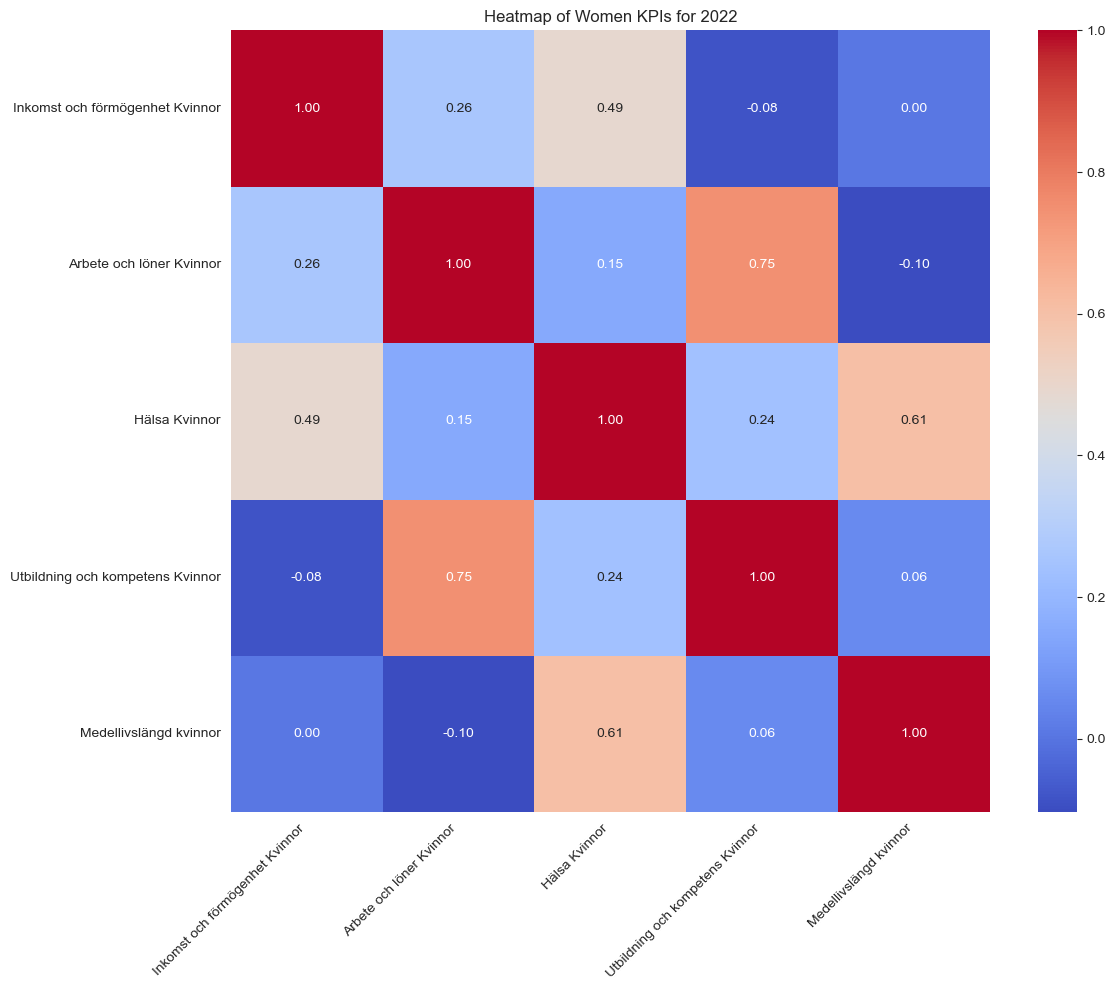

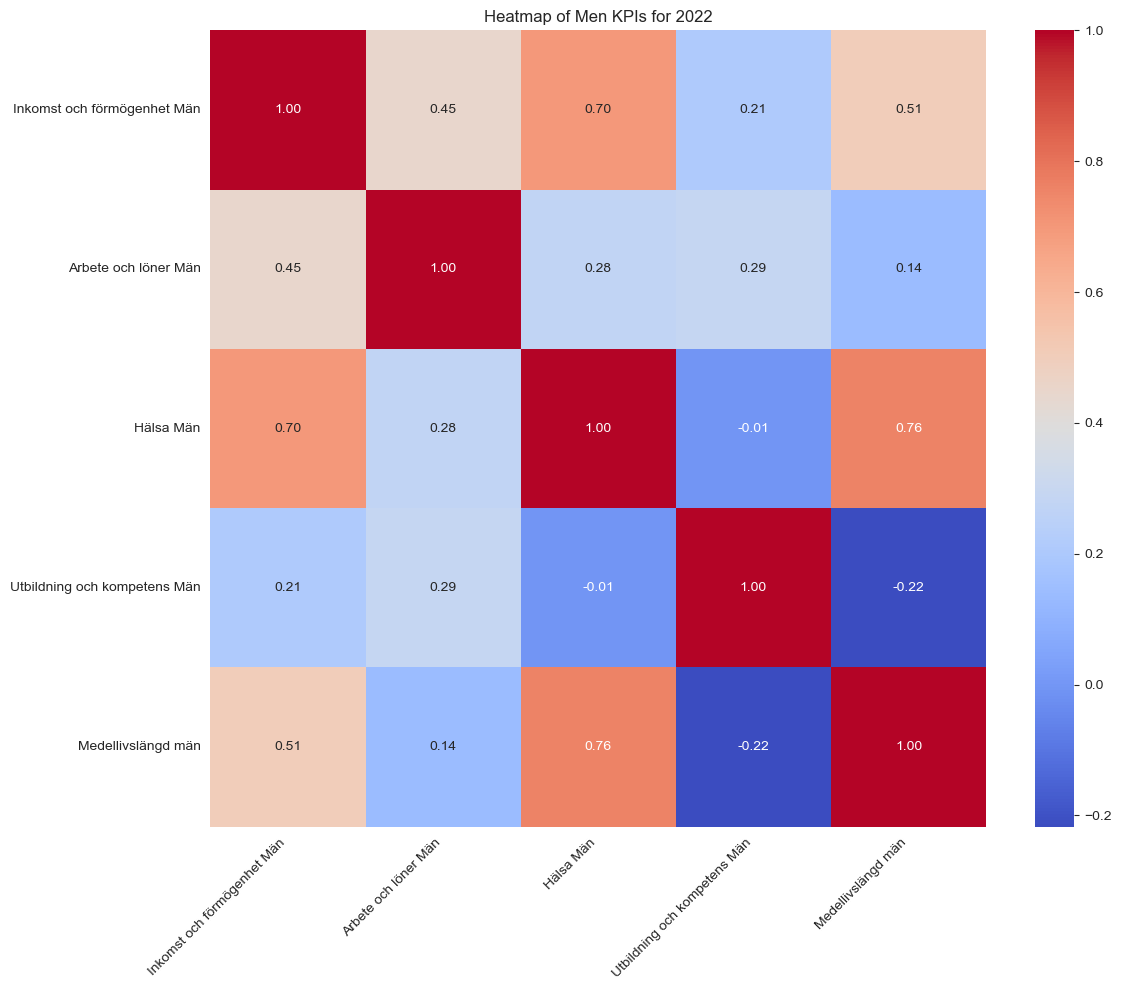

In [8]:
def create_heatmap(df, kpi_names, vars, gender):
    # Filter the DataFrame for the combined variables
    heatmap_df = df[df['kpi'].isin(vars)]

    # Pivot the DataFrame to get KPIs as columns, excluding 'municipality' from the index
    heatmap_df_pivot = heatmap_df.pivot_table(
        index='municipality',
        columns='kpi',
        values='value'
    )

    # Replace KPI IDs with names
    heatmap_df_pivot.columns = [kpi_names.get(col, col) for col in heatmap_df_pivot.columns]

    # Modify column names by removing unwanted parts of strings
    heatmap_df_pivot.columns = [col.replace(' – Regionindex', '').replace(', år', '') for col in heatmap_df_pivot.columns]

    # Calculate the correlation matrix, excluding 'municipality'
    corr_matrix = heatmap_df_pivot.corr(numeric_only=True)

    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Heatmap of {gender} KPIs for 2022')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

women_vars = independent_vars_women + dependent_vars_women
men_vars = independent_vars_men + dependent_vars_men
create_heatmap(df_2022, kpi_names, women_vars, 'Women')
create_heatmap(df_2022, kpi_names, men_vars, 'Men')

### Notable Observations from Heatmaps
**Women's KPIs:**
* **Income and Wealth vs Health:** Moderate positive correlation (0.49) suggests women's economic status may be associated with their health outcomes.
* **Work and Salary vs Education and Competence:** Strong positive correlation (0.75) highlights the critical impact of education on women's employment conditions and salaries.
* **Health vs Life Expectancy:** Significant positive correlation (0.61) indicates a close relationship between current health status and longevity for women.

**Men's KPIs:**
* **Income and Wealth vs Health:** Strong positive correlation (0.70) implies a substantial link between men's financial well-being and their health.
* **Income and Wealth vs Life Expectancy:** Moderate positive correlation (0.51) suggests economic status may contribute to men's longevity.
* **Health vs Life Expectancy:** Strong correlation (0.76) underscores the expected connection between health and life expectancy among men.

These observations reflect the complex interplay between socioeconomic factors and health outcomes with both similarities and differences across genders. For both men and women, higher income and wealth correlate with better health indices, but this relationship appears to be stronger for men. Additionally, education's link to work and salary conditions is notably strong for women emphasizing the importance of educational empowerment for economic equality.

### Exploratory Analysis Conclusion
Our exploratory analysis has revealed significant correlations between health, income, education and work related factors for both men and women in Sweden. A notable find is that being financially stable seems to have a strong correlation with health particularly for men. Whereas for women educational attainment shows a profound connection with work and salary conditions. These patterns underscore the influence of socioeconomic status on health outcomes and life expectancy.

For women, there is a sizeable association between health and income as well as between health and educational attainment. However, life expectancy for women does not show a strong dependence on these socioeconomic factors. On the other hand for men while health outcomes show correlations with both education and income, life expectancy has a stronger dependence on health than on socioeconomic factors.

The scatter plots and heatmaps collectively demonstrate that while income and wealth are strong indicators of health, education's role in economic opportunities especially for women are crucial. These insights highlight the gender-specific nuances in how socioeconomic determinants affect health outcomes in Sweden.

Our analysis supports the intricate connection between socioeconomic factors and health outcomes in Sweden. It demonstrates the significant role of financial conditions in men's health and underlines the influence of education on women's economic status. These correlations suggest that addressing health disparities requires a comprehensive approach that considers the intertwined nature of economic resources and educational access.

### Probability Distribution

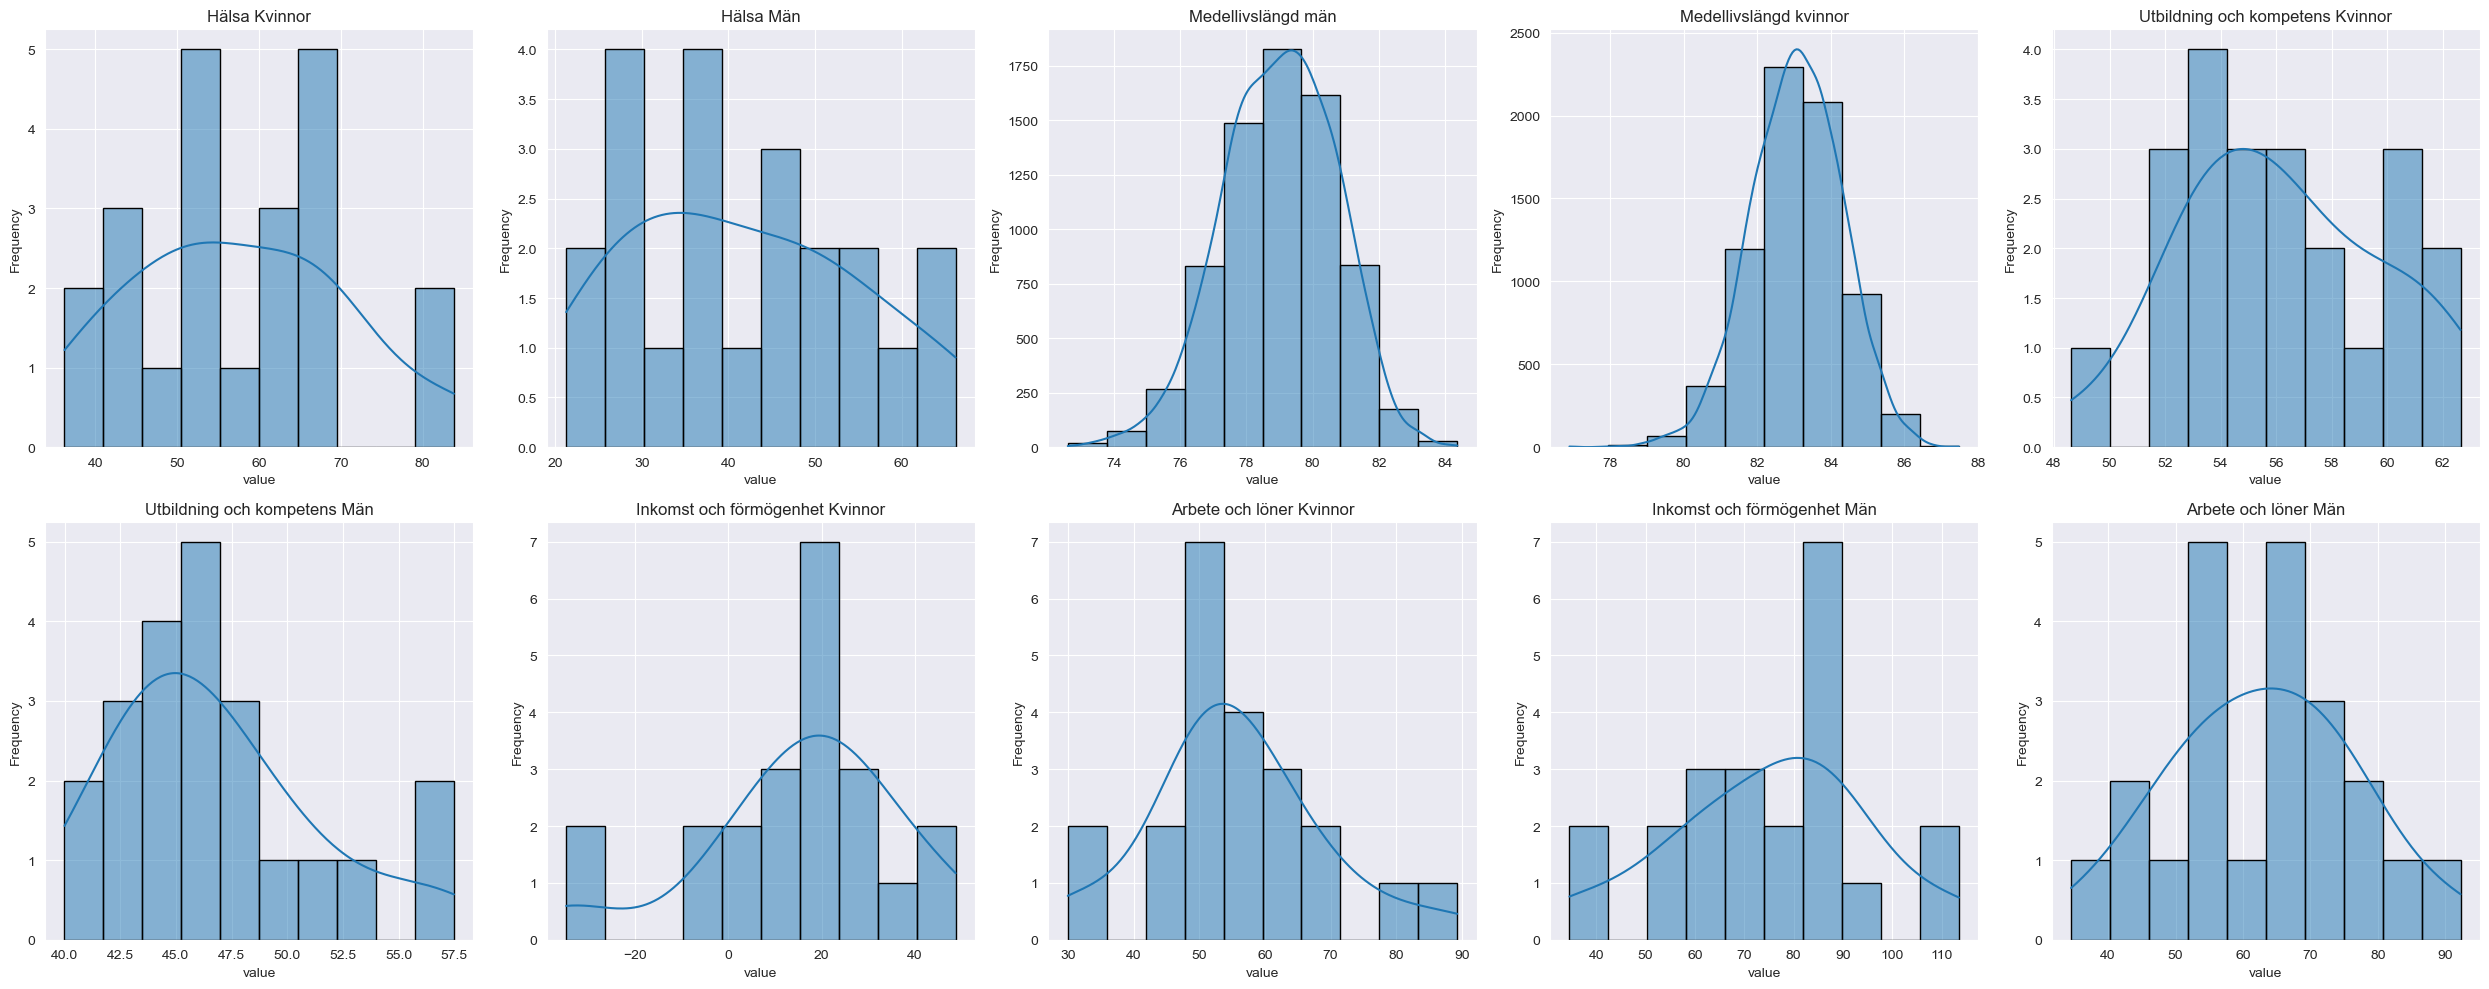

In [9]:
# Create a list with women and men variables
women_men_vars = women_vars + men_vars

# Filter Dataframe to only include the men and women kpis
women_men_df = all_kpis_df[all_kpis_df['kpi'].isin(women_men_vars)]

# Plot histograms to visualize the distributions of the variables
plot_kpi_histograms(women_men_df, kpi_names, num_bins=10, num_cols=5)

### Probability Distribution: Observations
The histograms provide a visual representation of the distribution of various health and socioeconomic variables. Below are the observations for each:

1. **Health Index for Women and Men (Hälsa Kvinnor/Män):**
The distributions for both women and men exhibit a nearly symmetrical shape with minor deviations suggesting that normal distribution might be a reasonable approximation.
2. **Income and Wealth for Women and Men (Inkomst och förmögenheter Kvinnor/Män):** 
The histograms reveal a pronounced right skew indicating that a considerable number of observations cluster on the lower end of the scale. This pattern is common for a log-normal distribution where higher values are less frequent but significantly impact the mean.
3. **Education and Competence for Women and Men (Utbildning och kompetens Kvinnor/Män):** 
Both histograms display a bell-shaped curve centered around the mean aligning with the characteristics of a normal distribution. This suggests that educational attainment is fairly consistent across the data.
4. **Work and Salary for Women (Arbete och löner Kvinnor):**
Upon log transformation the distribution of women's work and salary conditions approaches symmetry hinting at an underlying log-normal distribution. This reflects that while there is variability in work and salary conditions it conforms to a predictable pattern when adjusted for scale.
5. **Work and Salary for Men (Arbete och löner Män):**
Even after a log transformation the histogram for men's work and salary conditions exhibits a slight right skew. While not perfectly log-normal the distribution is close suggesting that salaries for men are generally higher with some outliers influencing the tail.

In [10]:
normal_kpis = ['N00351', 'N00925', 'N00352', 'N00348', 'N00362', 'N00923', 'N00363', 'N00359']
log_normal_kpis = ['N00349', 'N00360']

normal_params, log_normal_params = {}, {}

for kpi in normal_kpis:
    data = all_kpis_df[all_kpis_df['kpi'] == kpi]['value']
    normal_params[kpi] = {
        'mean': data.mean(),
        'std': data.std()
    }

for kpi in log_normal_kpis:
    # Ensure that data is strictly positive before log transformation
    data = all_kpis_df[all_kpis_df['kpi'] == kpi]['value']
    data = data[data > 0]

    logged_data = np.log(data)
    log_normal_params[kpi] = {
        'log_mean': logged_data.mean(),
        'log_std': logged_data.std()
    }

In [11]:
# Function to print the parameters of the distributions
def print_parameters(params, is_log_normal=False):
    for kpi, values in params.items():
        kpi_titles = kpi_names.get(kpi, kpi)
        mean_label = 'log_mean' if is_log_normal else 'mean'
        std_label = 'log_std' if is_log_normal else 'std'
        mean = round(values[mean_label], 2)
        std = round(values[std_label], 2)
        
        # Print the parameters and format the title string
        print(f'{kpi_titles.replace(", år", "").replace("Regionindex", "").replace(" – ", "").replace(", andel (%)", "").replace(" år (median), kr", "")}: Mean: {mean}, STD: {std}')

print("Normal distribution parameters:")
print_parameters(normal_params)

print("\nLog-normal distribution parameters:")
print_parameters(log_normal_params, is_log_normal=True)

Normal distribution parameters:
Hälsa Kvinnor: Mean: 57.61, STD: 13.28
Medellivslängd kvinnor: Mean: 83.07, STD: 1.25
Utbildning och kompetens Kvinnor: Mean: 56.23, STD: 3.67
Inkomst och förmögenhet Kvinnor: Mean: 15.5, STD: 21.22
Hälsa Män: Mean: 41.65, STD: 13.58
Medellivslängd män: Mean: 79.0, STD: 1.72
Utbildning och kompetens Män: Mean: 46.66, STD: 4.57
Inkomst och förmögenhet Män: Mean: 75.07, STD: 20.62

Log-normal distribution parameters:
Arbete och löner Kvinnor: Mean: 3.99, STD: 0.25
Arbete och löner Män: Mean: 4.12, STD: 0.23


### Estimation of Parameters Interpreted
#### Normal Distribution Parameters:
* `N00351`: Health Index for Women
  - Mean: 57.61
  - Standard Deviation: 13.28  
  This suggests a moderate average health index with a relatively wide-spread meaning that there is variability among women's health indices.

* `N00925`: Life Expectancy for Women
  - Mean: 83.07
  - Standard Deviation: 1.25  
  This indicates high life expectancy with low variability which shows that that life expectancy for women is quite consistent across the sample.

* `N00352`: Education and Competence for Women
  - Mean: 56.23
  - Standard Deviation: 3.67  
  A moderate average with relatively low variability representing that education and competence scores for women are quite consistent.

* `N00348`: Income and Wealth for Women
  - Mean: 15.50
  - Standard Deviation: 21.22  
  A lower average with very high variability which might suggest a wide disparity in income and wealth among women.

* `N00362`: Health Index for Men
  - Mean: 41.65
  - Standard Deviation: 13.58  
  A lower average compared to women with a wide-spread showing that there is variability among men's health indices.

* `N00923`: Life Expectancy for Men
  - Mean: 79.00
  - Standard Deviation: 1.72  
  High life expectancy with low variability which is similar to women showing a consistent life expectancy for men.

* `N00363`: Education and Competence for Men
  - Mean: 46.66
  - Standard Deviation: 4.57  
  A moderate average with relatively low variability representing that education and competence scores for men are quite consistent.

* `N00359`: Income and Wealth for Men
  - Mean: 75.07
  - Standard Deviation: 20.62  
  A higher average with high variability suggesting a wide disparity in income and wealth among men.

#### Log-normal Distribution Parameters:
* `N00349`: Work and Wages for Women (Log-transformed)
  - Log Mean: 3.99
  - Log Standard Deviation: 0.25  
  After log transformation, the mean and standard deviation suggest that the underlying distribution of logged values is moderately centered with some spread. This reflects multiplicative processes in the wages for women.

* `N00360`: Work and Wages for Men (Log-transformed)
  - Log Mean: 4.12
  - Log Standard Deviation: 0.23  
  Similar to the work and wages for women, after log transformation, the distribution of logged values appears moderately centered with low variability. This reflects multiplicative processes in the wages for men.


### Hypothesis Testing
#### Hypothesis 1_A:
* Null Hypothesis (H0_1A): There is no relationship between income and health among women.
* Alternative Hypothesis (H1_1A): There is a positive relationship between income and health among women.

#### Hypothesis 1_B:
* Null Hypothesis (H0_1B): There is no relationship between income and health among men.
* Alternative Hypothesis (H1_1B): There is a positive relationship between income and health among men.

#### Hypothesis 2_A:
* Null Hypothesis (H0_2A): There is no relationship between education and health among women.
* Alternative Hypothesis (H1_2A): There is a positive relationship between education and health among women.

#### Hypothesis 2_B:
* Null Hypothesis (H0_2B): There is no relationship between education and health among men.
* Alternative Hypothesis (H1_2B): There is a positive relationship between education and health among men.

#### Hypothesis 3_A:
* Null Hypothesis (H0_3A): The effect of income on health is greater than or equal to the effect of education on health among women.
* Alternative Hypothesis (H1_3A): The effect of education on health is greater than the effect of income on health among women.

#### Hypothesis 3_B:
* Null Hypothesis (H0_3B): The effect of income on health is greater than or equal to the effect of education on health among men.
* Alternative Hypothesis (H1_3B): The effect of education on health is greater than the effect of income on health among men.

In [12]:
# Filter the DataFrame for Health and Income KPIs by age
women_health_df = df_2022[df_2022['kpi'] == 'N00351']
women_income_df = df_2022[df_2022['kpi'] == 'N00348']
women_education_df = df_2022[df_2022['kpi'] == 'N00352']
men_health_df = df_2022[df_2022['kpi'] == 'N00362']
men_income_df = df_2022[df_2022['kpi'] == 'N00359']
men_education_df = df_2022[df_2022['kpi'] == 'N00363']

# Pivot the data
women_health_pivot = women_health_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'health'})
women_income_pivot = women_income_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'income'})
women_education_pivot = women_education_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'education'})
men_health_pivot = men_health_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'health'})
men_income_pivot = men_income_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'income'})
men_education_pivot = men_education_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'education'})

# Merge the pivoted data
merged_women_df = women_health_pivot.join(women_income_pivot, on=['municipality', 'gender']).join(women_education_pivot, on=['municipality', 'gender'])
merged_men_df = men_health_pivot.join(men_income_pivot, on=['municipality', 'gender']).join(men_education_pivot, on=['municipality', 'gender'])

# Determine the correlation between health and income among women
correlation_women_health_income, p_value_women_health_income = pearsonr(merged_women_df['health'], merged_women_df['income'])

# Determine the correlation between health and income among men
correlation_men_health_income, p_value_men_health_income = pearsonr(merged_men_df['health'], merged_men_df['income'])

# Determine the correlation between health and education among women
correlation_women_health_education, p_value_women_health_education = pearsonr(merged_women_df['health'], merged_women_df['education'])

# Determine the correlation between health and education among men
correlation_men_health_education, p_value_men_health_education = pearsonr(merged_men_df['health'], merged_men_df['education'])

# OLS regression to compare effects of income and education on health
model_women = smf.ols('health ~ income + education', data=merged_women_df).fit()
model_men = smf.ols('health ~ income + education', data=merged_men_df).fit()

In [13]:
# Results for Hypothesis 1A: Health and Income among women
print("Women - Health and Income Correlation")
print("Pearson correlation coefficient:", correlation_women_health_income)
print("P-value:", p_value_women_health_income)

# Results for Hypothesis 1B: Health and Income among men)
print("\nMen - Health and Income Correlation")
print("Pearson correlation coefficient:", correlation_men_health_income)
print('P-value:', p_value_men_health_income)

# Results for Hypothesis 2A: Health and Education among women
print("\nWomen - Health and Education Correlation")
print("Pearson correlation coefficient:", correlation_women_health_education)
print("P-value:", p_value_women_health_education)

# Results for Hypothesis 2B: Health and Education among men
print("\nMen - Health and Education Correlation")
print("Pearson correlation coefficient:", correlation_men_health_education)
print('P-value:', p_value_men_health_education)

Women - Health and Income Correlation
Pearson correlation coefficient: 0.4903352002041497
P-value: 0.020516279270103445

Men - Health and Income Correlation
Pearson correlation coefficient: 0.6964109636779228
P-value: 0.00031787766733710777

Women - Health and Education Correlation
Pearson correlation coefficient: 0.23814032028904936
P-value: 0.2858696864026953

Men - Health and Education Correlation
Pearson correlation coefficient: -0.0053175609276108135
P-value: 0.9812628183044294


In [14]:
# Results for Hypothesis 3A: Income vs Education on health among women
print("\nWomen - Income vs Education on health")
print(model_women.summary())

# Results for Hypothesis 3B: Income vs Education on health among men
print("\nMen - Income vs Education on health")
print(model_men.summary())


Women - Income vs Education on health
                            OLS Regression Results                            
Dep. Variable:                 health   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     4.454
Date:                Mon, 08 Jan 2024   Prob (F-statistic):             0.0259
Time:                        16:15:11   Log-Likelihood:                -83.370
No. Observations:                  22   AIC:                             172.7
Df Residuals:                      19   BIC:                             176.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

### Hypothesis Testing: Observations
#### Hypothesis 1A - Health and Income among Women:
* **Results:** Pearson correlation coefficient: 0.4903, P-value: 0.0205
* **Conclusion:** Given the p-value of 0.0205 is less than the significance level (alpha = 0.05), we reject the null hypothesis (H0_1A). This suggests there is a statistically significant positive correlation between health and income among women.

#### Hypothesis 1B - Health and Income among Men:
* **Results:** Pearson correlation coefficient: 0.6964, P-value: 0.0003
* **Conclusion:** The p-value of 0.0003 is well below the significance level, leading us to reject the null hypothesis (H0_1B). This indicates a statistically significant positive correlation between health and income among men, and the correlation appears stronger compared to women.

#### Hypothesis 2A - Health and Education among Women:
* **Results:** Pearson correlation coefficient: 0.2381, P-value: 0.2859
* **Conclusion:** The p-value of 0.2859 exceeds the alpha level of 0.05, suggesting we fail to reject the null hypothesis (H0_2A). This implies that the correlation between health and education among women is not statistically significant.

#### Hypothesis 2B - Health and Education among Men:
* **Results:** Pearson correlation coefficient: -0.0053, P-value: 0.9813
* **Conclusion:** With a p-value of 0.9813, we fail to reject the null hypothesis (H0_2B). This indicates no significant correlation between health and education among men.

#### Hypothesis 3A - Income vs Education on Health among Women:
* **Results:** Income Coefficient: 0.3217 (p = 0.014), Education Coefficient: 1.0193 (p = 0.155)
* **Conclusion:** The effect of income on health is statistically significant and positive, while the effect of education is not significant. This suggests that income has a more pronounced impact on health than education for women.

#### Hypothesis 3B - Income vs Education on Health among Men:
* **Results:** Income Coefficient: 0.4804 (p < 0.001), Education Coefficient: -0.4721 (p = 0.346)
* **Conclusion:** Income shows a significant positive effect on health whereas education does not show a significant effect and tends to have a negative coefficient. This implies that for men income has a greater effect on health compared to education.

### Predictive Analysis

In [15]:
def run_regression_model(df, dependent_kpi, independent_kpis):
    # Pivot the data to get KPIs as columns
    df_pivot = df.pivot_table(index='municipality', columns='kpi', values='value')

    # Fill NaN values with the mean of each column
    df_pivot_filled = df_pivot.fillna(df_pivot.mean())

    # Define the independent variables
    X = df_pivot_filled[independent_kpis]

    # Define the dependent variable
    y = df_pivot_filled[dependent_kpi]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Add a constant to the model (for the intercept)
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test)

    # Create and train the linear regression model using statsmodels
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Get predictions
    y_pred = model.predict(X_test_with_const)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    # Output the model's summary and MSE
    print(f"Model Summary for Dependent KPI: {dependent_kpi}")
    print(model.summary())
    print("\nMean Squared Error:", mse)

In [16]:
# Filter the data to only include the regional municipalities
regional_df = df_2022[df_2022['municipality'].isin(range(26))]

# Independent KPIs including confounding variables
independent_women_kpis = ['N00352', 'N00348', 'N00349', 'U01402', 'U01405', 'U01411']
independent_men_kpis = ['N00363', 'N00359', 'N00360', 'U01402', 'U01405', 'U01411']

# Run the regression model for Health Index for Women
run_regression_model(regional_df, 'N00351', independent_women_kpis)

# Run the regression model for Life Expectancy for Women
run_regression_model(regional_df, 'N00925', independent_women_kpis)

# Run the regression model for Health Index for Men
run_regression_model(regional_df, 'N00362', independent_men_kpis)

# Run the regression model for Life Expectancy for Men
run_regression_model(regional_df, 'N00923', independent_men_kpis)

Model Summary for Dependent KPI: N00351
                            OLS Regression Results                            
Dep. Variable:                 N00351   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     19.02
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           6.21e-05
Time:                        16:15:11   Log-Likelihood:                -44.514
No. Observations:                  17   AIC:                             103.0
Df Residuals:                      10   BIC:                             108.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [17]:
# Nearest Neighbors Regression Model
def run_knn_model(df, dependent_kpi, independent_kpis, n_neighbors=5):
    # Pivot the data to get KPIs as columns
    df_pivot = df.pivot_table(index='municipality', columns='kpi', values='value')

    # Fill NaN values with the mean of each column
    df_pivot_filled = df_pivot.fillna(df_pivot.mean())

    # Define the independent variables
    X = df_pivot_filled[independent_kpis]

    # Define the dependent variable
    y = df_pivot_filled[dependent_kpi]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create and train the K-Nearest Neighbors model
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Get predictions
    y_pred = knn_model.predict(X_test)

    # Calculate Mean Squared Error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Output the model's MSE and R-squared
    print(f"K-Nearest Neighbors Model Summary for Dependent KPI: {dependent_kpi}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}\n")

In [18]:
run_knn_model(regional_df, 'N00351', independent_women_kpis)  # For women's health index
run_knn_model(regional_df, 'N00925', independent_women_kpis)  # For women's life expectancy
run_knn_model(regional_df, 'N00362', independent_men_kpis) # For men's health index
run_knn_model(regional_df, 'N00923', independent_men_kpis) # For men's life expectancy

K-Nearest Neighbors Model Summary for Dependent KPI: N00351
Mean Squared Error: 226.1529985369741
R-squared: 0.17177812356203925

K-Nearest Neighbors Model Summary for Dependent KPI: N00925
Mean Squared Error: 0.2382384000000029
R-squared: -0.6695520547177083

K-Nearest Neighbors Model Summary for Dependent KPI: N00362
Mean Squared Error: 155.14669701800608
R-squared: 0.25981378162053936

K-Nearest Neighbors Model Summary for Dependent KPI: N00923
Mean Squared Error: 0.0820392000000045
R-squared: 0.26698355968545595


### Hypothesis Testing for Predictive Models

#### Hypothesis 1 - Predictive model comparison
* Null Hypothesis (H0_1): There is no difference in performance between the linear regression and K-Nearest Neighbors models.
* Alternative Hypothesis (H1_1): There is a difference in performance between the linear regression and K-Nearest Neighbors models.

In [19]:
def compare_model_performance(df, dependent_kpi, independent_kpis, n_neighbors=5, cv_folds=10):
    # Pivot the data to get KPIs as columns
    df_pivot = df.pivot_table(index='municipality', columns='kpi', values='value')
    
    # Fill NaN values with the mean of each column
    df_pivot_filled = df_pivot.fillna(df_pivot.mean())
    
    # Define the independent variables
    X = df_pivot_filled[independent_kpis]
    
    # Define the dependent variable
    y = df_pivot_filled[dependent_kpi]

    # Define the models
    model_lr = LinearRegression()
    model_knn = KNeighborsRegressor(n_neighbors=n_neighbors)

    # Perform cross-validation
    scores_lr = cross_val_score(model_lr, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    scores_knn = cross_val_score(model_knn, X, y, cv=cv_folds, scoring='neg_mean_squared_error')

    # Convert scores to positive MSE
    scores_lr = -scores_lr
    scores_knn = -scores_knn

    # Perform paired t-test
    t_statistic, p_value = ttest_rel(scores_lr, scores_knn)

    # Output the results
    print(f"Linear Regression vs K-Nearest Neighbors Model Comparison:")
    print(f"T-statistic: {t_statistic}, P-value: {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis - Significant difference in model performance\n")
    else:
        print(f"Fail to reject the null hypothesis - No significant difference in model performance\n")

In [20]:
# Run the comparison for Health Index for Women
compare_model_performance(regional_df, 'N00351', independent_women_kpis)

# Run the comparison for Life Expectancy for Women
compare_model_performance(regional_df, 'N00925', independent_women_kpis)

# Run the comparison for Health Index for Men
compare_model_performance(regional_df, 'N00362', independent_men_kpis)

# Run the comparison for Life Expectancy for Men
compare_model_performance(regional_df, 'N00923', independent_men_kpis)

Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -3.4377439434849366, P-value: 0.007416904666533441
Reject the null hypothesis - Significant difference in model performance
Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -2.327399404637589, P-value: 0.044938081705504236
Reject the null hypothesis - Significant difference in model performance

Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -2.9123270469994393, P-value: 0.017245809093807272
Reject the null hypothesis - Significant difference in model performance

Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -1.182471839219318, P-value: 0.26731524828605707
Fail to reject the null hypothesis - No significant difference in model performance


### Predictive Analysis: Observations
In our predictive models, our examination has distinctly shown the superior performance of the linear regression model when compared to the K-Nearest Neighbors (KNN) approach.

#### Comparative Results:
For the **Health Index for Women and Men**, the linear regression model delivered an R-squared of 0.887 and 0.724 respectively. The linear regression model significantly outperformed the KNN model's R-squared of 0.172 and 0.260. This metric reflects the model's accuracy in explaining the variability of the health index.   

Regarding the Life Expectancy for Women and Men, the linear regression model again demonstrated higher efficiency with R-squared values of 0.474 and 0.770 respectively. In comparison, the KNN model for women produced a negative R-squared indicating a poor fit.

#### Statistical Significance:
The hypothesis tests conducted to compare model performances revealed statistically significant differences favoring the linear regression model for the Health Index in both genders and for women's Life Expectancy as evidenced by the low p-values obtained. Only for men's Life Expectancy was the performance difference not statistically significant.

#### Implications of Model Selection:
These results underscore the adequacy of linear regression as a predictive tool in our study likely due to its ability to capture linear relationships in the data effectively. The KNN model, while useful in certain contexts did not align as well with the underlying patterns of our specific dataset.

This preference for linear regression is rooted not just in its predictive power but also in its interpretability which is crucial for understanding the relationship between variables in a real-world context.

### Conclusion

* State again your problem and the motivation.
* Draw a final conclusion.
* If you keep working on this project, what would be the next step?   

### References:
- Silhouette (clustering) (2023). Available at: https://en.wikipedia.org/wiki/Silhouette_%28clustering%29 (Accessed: 10 December 2023).